In [1]:
! pip install torchinfo

# GAN

Цели:

* Разобраться с GAN - реализация на pytorch "from scratch"
* Познакомиться со сверточной версией GAN - что это за зверь, для чего применяется
* Познакомиться с условной генерацией в GAN

Содержание:

* [Введение](#intro)
* [Загрузка данных](#load_data)
* GAN
  * [код Generator'а](#gan_gen_code)
  * [код Discriminator'а](#gan_disc_code)
  * [цикл обучения](#gan_train)
  * [генерация из случайных весов](#ae_generation)
* Deep Convolutional GAN
  * [код Generator'а](#dcgan_gen_code)
  * [код Discriminator'а](#dcgan_disc_code)
  * [цикл обучения](#dcgan_train)
* Deep Convolutional Conditional GAN
  * [код Generator'а](#dccgan_gen_code)
  * [код Discriminator'а](#dccgan_disc_code)
* Упражнения

Ссылки:

* [Книга Deep Learning от Иана Гудфеллоу](https://www.deeplearningbook.org/contents/generative_models.html)
* Примеры реализаций GAN - [раз](https://nn.labml.ai/gan/index.html) и [два](https://github.com/eriklindernoren/PyTorch-GAN)
* [Видео лекции Иана Гудфеллоу](https://www.youtube.com/watch?v=HGYYEUSm-0Q)
* [объяснение от Yannic Kilcher на YouTube](https://www.youtube.com/watch?v=eyxmSmjmNS0)


<a name="intro"></a>
## Введение


Генеративно-состязательную сеть описал Ян Гудфеллоу из компании Google в 2014 году. Возглавлял подразделение машинного обучения в Apple, а сейчас работает в DeepMind. Принцип состязательности в сети GAN нередко описывается через метафоры.

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/rnn/gan_scheme.png" alt="Drawing" width= "800px;"/>

Назовем нашего фальшивомонетчика $G$ (или generator), а банкира — $D$ (или discriminator). У нас есть какое-то количество оригинальных денег $X$ для банкира, и пусть на выходе у него будет число диапазоном от нуля до единицы, чтобы оно выражало уверенность банкира в том, что выданные ему на рассмотрение деньги настоящие. Еще — поскольку фальшивомонетчик у нас нейронная сеть, ей нужны какие-то входные данные, назовем их $z$ - это наш случайный шум, который модель будет стараться превратить в деньги.


Тогда, очевидно, цель фальшивомонетчика — это максимизировать $D(G(z))$, то есть сделать так, чтобы банкир был уверен, что подделки — настоящие.
Цель банкира посложнее — ему нужно одновременно положительно опознавать оригиналы, и отрицательно — подделки.
![GAN1](https://developers.google.com/static/machine-learning/gan/images/bad_gan.svg?hl=ru)
![GAN2](https://developers.google.com/static/machine-learning/gan/images/ok_gan.svg?hl=ru)
![GAN3](https://developers.google.com/static/machine-learning/gan/images/good_gan.svg?hl=ru)
Запишем это как максимизацию $D(x)(1-D(G(z)))$. Умножение можно превратить в сложение, если взять логарифм, поэтому получаем:

Для банкира: максимизировать $log(D(X))+log(1-D(G(z)))$

Для фальшивомонетчика: максимизировать $log(D(G(z)))$

![minmax loss](https://theaisummer.com/static/16451c8109d2540415babbfd245fe0cc/d80c4/gan_training.jpg)

Мы знаем, что дискриминатор максимизирует эту функцию относительно своих параметров $\theta_d$, где при фиксированном генераторе ${G}_{\theta_{g}}$ он выполняет бинарную классификацию: он присваивает вероятность 1 точкам данных из обучающего набора $E_{x∼p_{data}}$ и присваивает вероятность 0 сгенерированным выборкам $E_{z∼p(z)}$

Поскольку используется подход из теории игр, наша лосс-функция представлена как минимаксная функция. Дискриминатор пытается максимизировать целевую функцию, поэтому мы можем выполнить градиентный подъем целевой функции. Генератор пытается минимизировать целевую функцию, поэтому мы можем выполнить градиентный спуск для целевой функции. Посредством чередования градиентного подъема и спуска сеть можно обучить.




В процессе совместного конкурентного обучения, если система достаточно сбалансирована, достигается минимаксное состояние равновесия, в котором обе сети значительно улучшили своё качество, и теперь сгенерированные изображения могут быть использованы практически как настоящие.

Если же мы сначала обучим дискриминатор (сделаем его "сильным критиком"), то генератор просто не сможет обучиться.

**Преимущества GAN**
* Теоретические гарантии сходимости (показано, что лосс ГАНов при *правильном* подборе параметров обеспечивает правильную  генерацию)
* Решает в явном виде задачу generative modeling

**Недостатки GAN**
* Нестабильное обучение
* Очень долгая сходимость (Неспособность сходиться)
* Mode-collapsing
* Generator starvation
* Поиск оптимальных параметров - **pure luck**


Вначале мы импортируем пакеты и набор данных, который мы будем использовать для создания и обучения GAN.

In [2]:
import numpy as np

import torchvision.transforms as transforms
from torchvision.datasets import MNIST

from torch.utils.data import DataLoader
from torch.autograd import Variable

import torch.nn as nn
import torch
from torchinfo import summary
# Visualize result
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

plt.rcParams.update({'figure.max_open_warning': 0})

Обучающие изображения, которые будет использовать ваш дискриминатор, взяты из набора данных [MNIST](http://yann.lecun.com/exdb/mnist/). Он содержит 60 000 изображений рукописных цифр от 0 до 9, таких как эти:

![MNIST Цифры](https://raw.githubusercontent.com/sswt/dive2gai/main/unit2/data/MnistExamples.png)

In [3]:
channels = 1 # suggested default : 1, number of image channels (gray scale)
img_size = 28 # suggested default : 28, size of each image dimension
img_shape = (channels, img_size, img_size) # (Channels, Image Size(H), Image Size(W))
latent_dim = 100 # suggested default. dimensionality of the latent space
sample_interval = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cuda = torch.cuda.is_available()

# Шум
Разберемся с **элементом случайности**. В нейронных сетях мы привыкли к **воспроизводимости** результата: в режиме валидации мы можем несколько раз подать на вход один и тот же объект и получить один и тот результат.  Возникает два вопроса:
- что подавать на **вход** сети для генерации?
- как реализовать **случайность**?

Ответ на оба вопроса: подавать в качестве **входа** вектор **случайного шума**.

Каждую компоненту латентного пространства (шума) можно рассматривать как отдельную шкалу, вдоль которой изменяются определенные свойства генерируемых объектов. Например, можно выбрать четыре латентных вектора и посмотреть, как генерируемые объекты плавно изменяются при переходе от одного вектора к другому.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L14/input_latent_space_lin_interpol.png" width="600">

<center><em>Линейные интерполяции между четырьмя изображениями в латентном пространстве</em></center>

<center><em>Source: <a href="https://arxiv.org/abs/1803.09093">Comparing Generative Adversarial Network Techniques for Image Creation and Modification(M. Pieters, M. Wiering, 2018)</a></em></center>

### Размерность входного латентного пространства
В выборе размерности входного латентного пространства важно соблюсти  баланс.
- при **низкой размерности** возникнет проблема **низкой вариабельности**.

Пример: генератор лиц с входным вектором длины 1. Результатом работы генератора будет всего одна шкала, вдоль которой будут расположены генерируемые изображения. Скорее всего, генератор выучит наиболее простую и "очевидную" шкалу: от молодой женщины блондинки к пожилому мужчине брюнету. У такой сети будет низкая вариабельность — она не сможет сгенерировать, например, рыжего ребенка в очках.
- при **большой размерности** латентное пространство может быть слишком **разреженным**.

При обучении модели количество точек в этом латентном пространстве будет настолько мало, что в основном пространство будет состоять из пустот. Тогда модель будет крайне некачественно генерировать объекты в точках латентного пространства, далеких от точек обучающей выборки.

In [4]:
# TODO: Сделать единую функцию display_images

def display_images(in_, out, row_count = 4, n=1, epoch=0, iteration=0):
    """Displaying routine"""
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(12, 4))
            for i in range(row_count):
                plt.subplot(1,row_count,i+1)
                plt.imshow(in_pic[i+row_count*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(12, 4))
        if iteration != 0:
            plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, iteration+1))
        for i in range(row_count):
            plt.subplot(1,row_count,i+1)
            plt.imshow(out_pic[i+row_count*N])
            plt.axis('off')
        plt.show()

def to_img(y):
    """Convert vector to image"""
    y = 0.5 * (y + 1)
    y = y.view(y.size(0), 28, 28)
    return y


def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)


set_default(figsize=(12, 3))

## Генератор
Первым шагом является создание компонента генератора. Генератор учится создавать поддельные данные, используя обратную связь от дискриминатора. Он учится заставлять дискриминатор классифицировать свой вывод как реальный.
Генератор включает в себя:
* случайный ввод
* сеть генератора, которая преобразует случайный ввод в экземпляр данных
* сеть дискриминатора, которая классифицирует сгенерированные данные
* выход дискриминатора
* потеря генератора, которая наказывает генератор за то, что он не смог обмануть дискриминатор
![Gen](https://developers.google.com/static/machine-learning/gan/images/gan_diagram_generator.svg?hl=ru)



## Реализация
Начнем с создания функции для создания одного слоя/блока нейронной сети генератора. Каждый блок должен включать в себя [линейное преобразование](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) для отображения на другую форму, [пакетную нормализацию](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) для стабилизации обучения и, наконец, нелинейную функцию активации (мы используем [LeakyReLU](https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html#torch.nn.LeakyReLU))

*Примечание: Мы используем LeakyReLU для предотвращения проблемы "мертвых нейронов", под которой понимается явление, когда параметры перестают изменяться из-за постоянно отрицательных значений, передаваемых в ReLU, что приводит к нулевому градиенту.

Rectified Linear Unit (ReLU) |  Leaky ReLU
:-------------------------:|:-------------------------:
![](https://raw.githubusercontent.com/sswt/dive2gai/main/unit2/data/relu-graph.png)  |  ![](https://raw.githubusercontent.com/sswt/dive2gai/main/unit2/data/lrelu-graph.png)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(input_features, output_features, normalize=True):
            layers = [nn.Linear(input_features, output_features)]
            if normalize: # Default
                layers.append(nn.BatchNorm1d(output_features, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True)) # inplace=True : modify the input directly. It can slightly decrease the memory usage.
            return layers # return list of layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), # Asterisk('*') in front of block means unpacking list of layers - leave only values(layers) in list
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))), # np.prod(1, 28, 28) == 1*28*28
            nn.Tanh() # result : from -1 to 1
        )

    def forward(self, z): # z == latent vector(random input vector)
        img = self.model(z) # (64, 100) --(model)--> (64, 784)
        img = img.view(img.size(0), *img_shape) # img.size(0) == N(Batch Size), (N, C, H, W) == default --> (64, 1, 28, 28)
        return img

summary(Generator().to(device), (1, 100))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 1, 28, 28]            --
├─Sequential: 1-1                        [1, 784]                  --
│    └─Linear: 2-1                       [1, 128]                  12,928
│    └─LeakyReLU: 2-2                    [1, 128]                  --
│    └─Linear: 2-3                       [1, 256]                  33,024
│    └─BatchNorm1d: 2-4                  [1, 256]                  512
│    └─LeakyReLU: 2-5                    [1, 256]                  --
│    └─Linear: 2-6                       [1, 512]                  131,584
│    └─BatchNorm1d: 2-7                  [1, 512]                  1,024
│    └─LeakyReLU: 2-8                    [1, 512]                  --
│    └─Linear: 2-9                       [1, 1024]                 525,312
│    └─BatchNorm1d: 2-10                 [1, 1024]                 2,048
│    └─LeakyReLU: 2-11                   [1, 1024]          

## Дискриминатор

Дискриминатор в GAN — это просто классификатор. Он пытается отличить реальные данные от данных, созданных генератором. Он может использовать любую сетевую архитектуру, соответствующую типу данных, которые он классифицирует.

![Discriminator](https://developers.google.com/static/machine-learning/gan/images/gan_diagram_discriminator.svg?hl=ru)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512), # (28*28, 512)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid() # result : from 0 to 1
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1) #flatten -> from (64, 1, 28, 28) to (64, 1*28*28)
        validity = self.model(img_flat) # Discriminate -> Real? or Fake? (64, 784) -> (64, 1)
        return validity
summary(Discriminator().to(device), (1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 512]                  401,920
│    └─LeakyReLU: 2-2                    [1, 512]                  --
│    └─Linear: 2-3                       [1, 256]                  131,328
│    └─LeakyReLU: 2-4                    [1, 256]                  --
│    └─Linear: 2-5                       [1, 1]                    257
│    └─Sigmoid: 2-6                      [1, 1]                    --
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
Total mult-adds (M): 0.53
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.13
Estimated Total Size (MB): 2.14

## Функции потерь

GAN пытаются воспроизвести распределение вероятностей. Поэтому они должны использовать функции потерь, которые отражают расстояние между распределением данных, сгенерированных GAN, и распределением реальных данных.
Варианты:
* Минимаксные потери
* Вассерштейна потеря

In [43]:
adversarial_loss = torch.nn.BCELoss()
generator = Generator()
discriminator = Discriminator()

In [44]:
generator

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [45]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [46]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

## Загрузка Данных

In [47]:
batch_size = 256

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # to scale images from [0, 1] to [-1, -1]
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [48]:
temp_img, _ =  dataset.__getitem__(0) # We don't need label, so _

In [49]:
temp_img.size()

torch.Size([1, 28, 28])

In [50]:
temp_img.max(), temp_img.min() # before Normalize([0.5],[0.5]) : 0 ~ 1, after : -1 ~ 1

(tensor(1.), tensor(-1.))

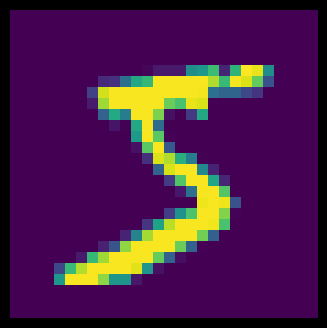

In [51]:
display_images(None, temp_img, row_count=1)

In [52]:
inputs, classes = next(iter(dataloader))

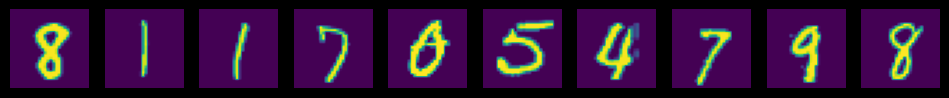

In [53]:
display_images(None, inputs, row_count=10)

In [54]:
# Define data loading step

batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [55]:
# suggested default - beta parameters (decay of first order momentum of gradients)
b1 = 0.5
b2 = 0.999

# suggested default - learning rate
lr = 0.0002

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1,b2))

In [56]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# Обучение
Поскольку GAN содержит две отдельно обученные сети, алгоритм обучения должен решать две проблемы:

* GAN должны совмещать два разных вида обучения (генератор и дискриминатор).
* Сходимость GAN трудно идентифицировать.

Обучение GAN проходит следующим образом:
1. Дискриминатор обучается в течение одной или нескольких итераций.
2. Генератор обучается в течение одной или нескольких итераций.
3. Повторяем шаги 1 и 2.

**Сходимость**

По мере того, как генератор улучшается с обучением, производительность дискриминатора ухудшается, потому что дискриминатор не может легко отличить настоящее от подделки. Если генератор работает идеально, то точность дискриминатора составляет 50%. По сути, дискриминатор подбрасывает монету, чтобы сделать свой прогноз.

Это прогрессирование создает проблему для сходимости GAN в целом: обратная связь дискриминатора со временем становится менее значимой. Если GAN продолжает обучение после точки, когда дискриминатор дает полностью случайную обратную связь, тогда генератор начинает обучаться на ненужной обратной связи, и его собственное качество может рухнуть.


  0%|          | 0/235 [00:00<?, ?it/s]

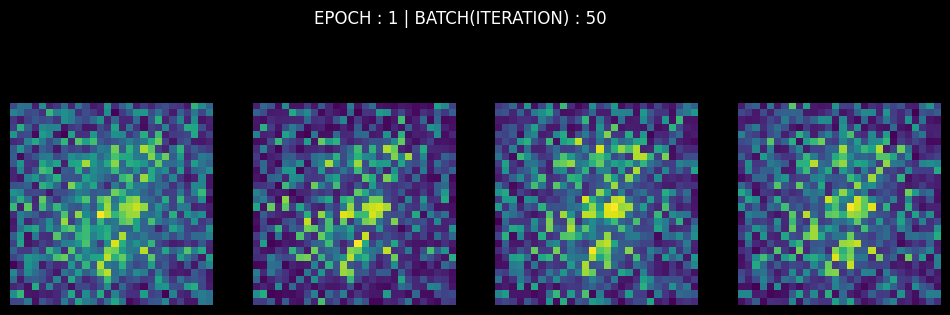

[Epoch: 1/50] [Batch: 235/235] [D loss: 0.561396] [G loss: 0.713779]


  0%|          | 0/235 [00:00<?, ?it/s]

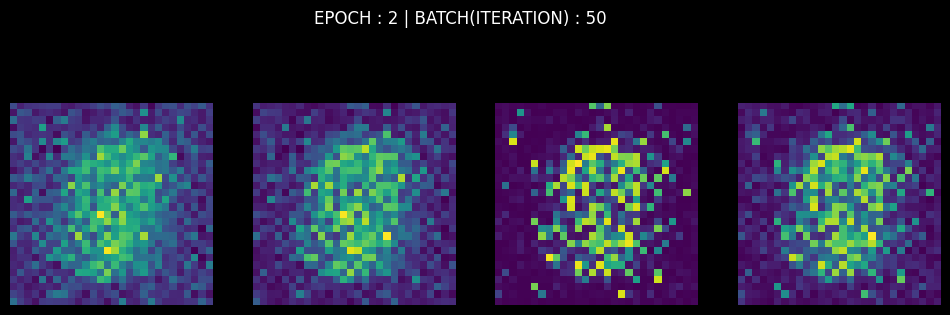

[Epoch: 2/50] [Batch: 235/235] [D loss: 0.531527] [G loss: 0.665740]


  0%|          | 0/235 [00:00<?, ?it/s]

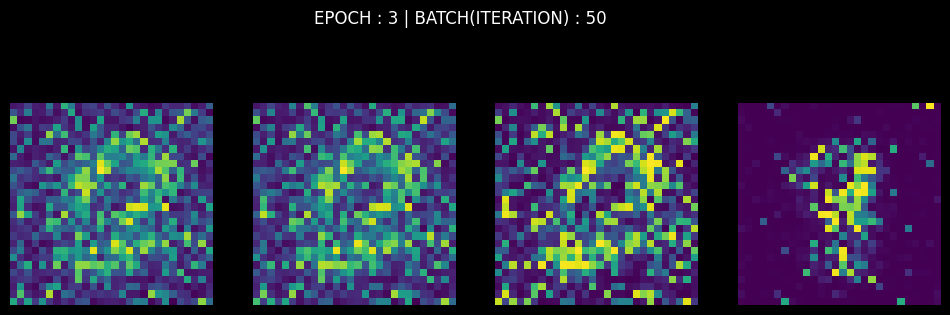

[Epoch: 3/50] [Batch: 235/235] [D loss: 0.592251] [G loss: 0.487767]


  0%|          | 0/235 [00:00<?, ?it/s]

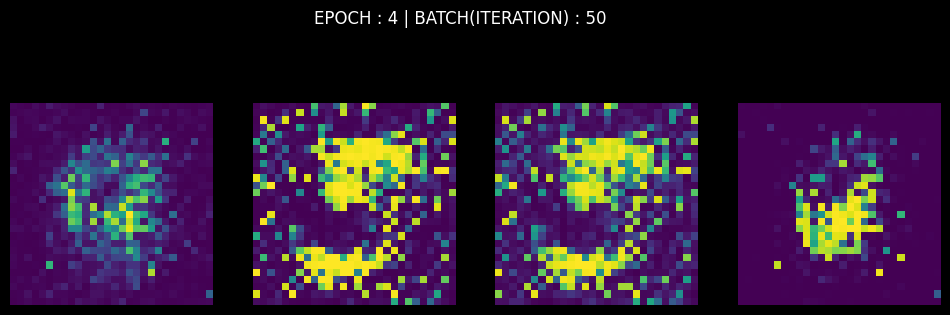

[Epoch: 4/50] [Batch: 235/235] [D loss: 0.475043] [G loss: 0.598181]


  0%|          | 0/235 [00:00<?, ?it/s]

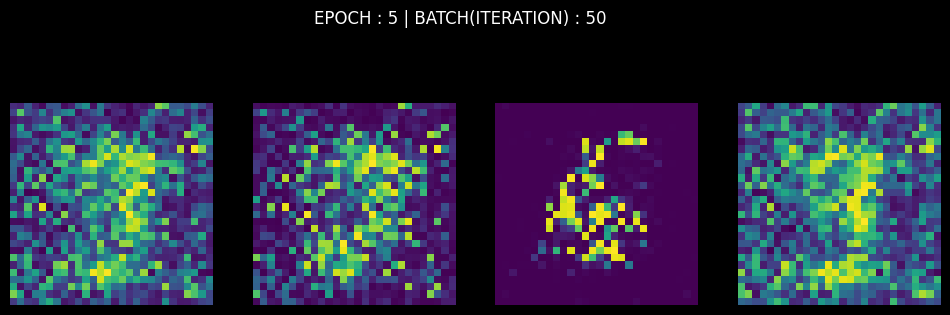

[Epoch: 5/50] [Batch: 235/235] [D loss: 0.654091] [G loss: 0.391346]


  0%|          | 0/235 [00:00<?, ?it/s]

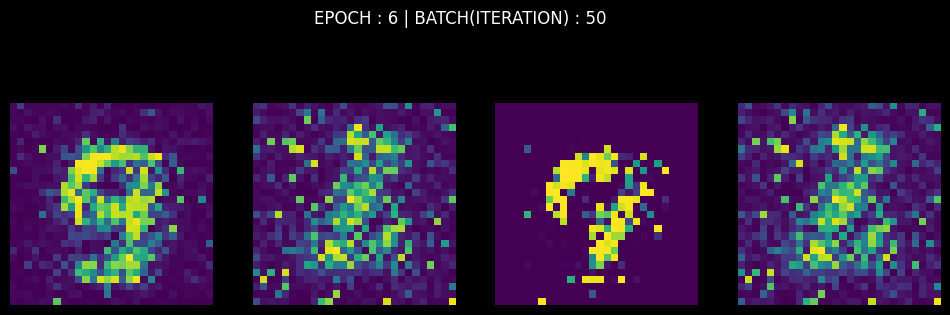

[Epoch: 6/50] [Batch: 235/235] [D loss: 0.392711] [G loss: 1.292480]


  0%|          | 0/235 [00:00<?, ?it/s]

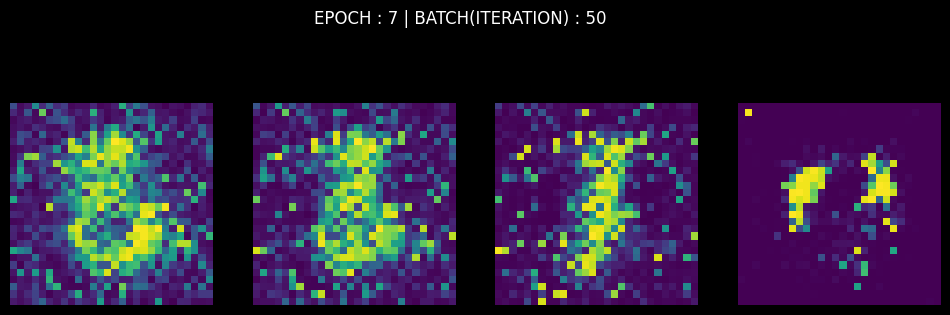

[Epoch: 7/50] [Batch: 235/235] [D loss: 0.437878] [G loss: 2.624002]


  0%|          | 0/235 [00:00<?, ?it/s]

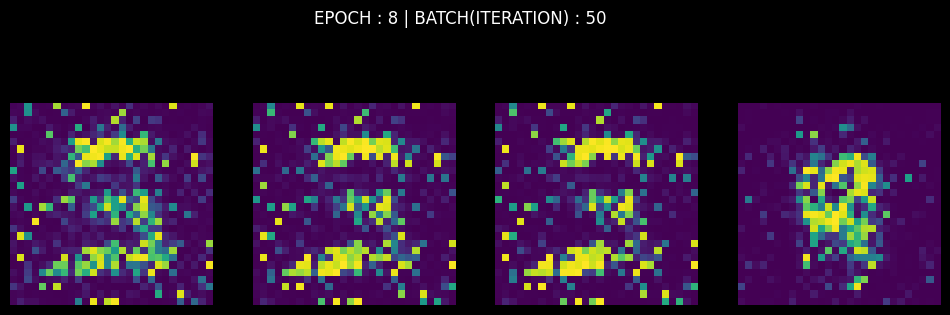

[Epoch: 8/50] [Batch: 235/235] [D loss: 0.498933] [G loss: 0.565750]


  0%|          | 0/235 [00:00<?, ?it/s]

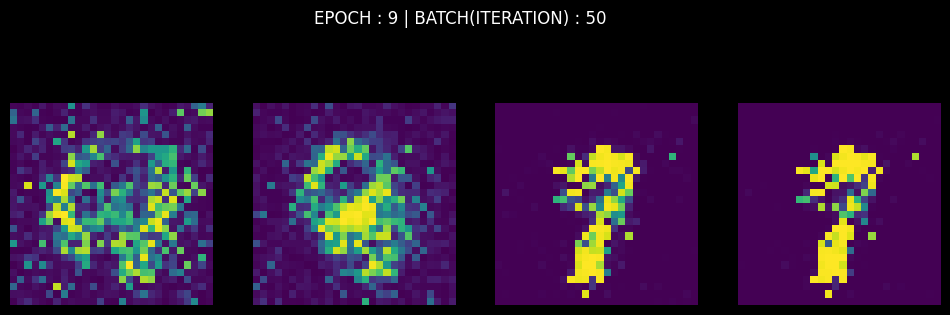

[Epoch: 9/50] [Batch: 235/235] [D loss: 0.334087] [G loss: 2.406204]


  0%|          | 0/235 [00:00<?, ?it/s]

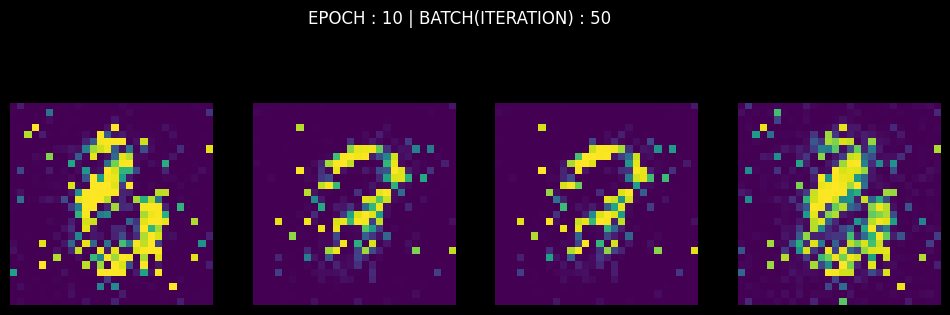

[Epoch: 10/50] [Batch: 235/235] [D loss: 0.323060] [G loss: 1.286886]


  0%|          | 0/235 [00:00<?, ?it/s]

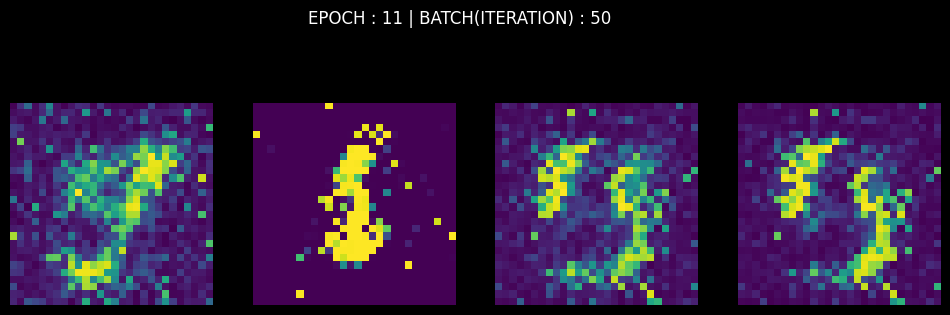

[Epoch: 11/50] [Batch: 235/235] [D loss: 0.310606] [G loss: 0.926349]


  0%|          | 0/235 [00:00<?, ?it/s]

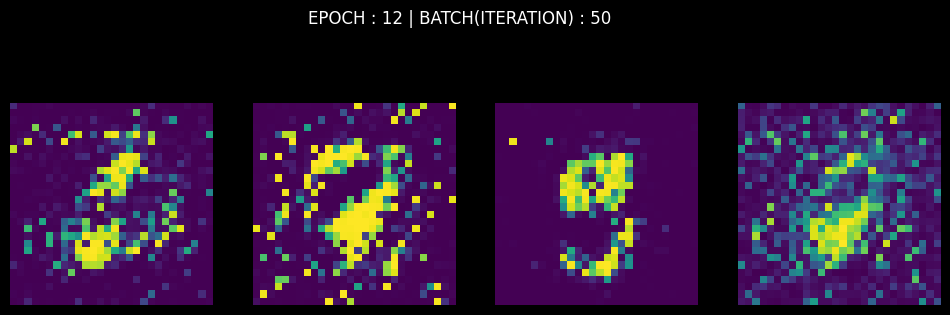

[Epoch: 12/50] [Batch: 235/235] [D loss: 0.260485] [G loss: 2.523078]


  0%|          | 0/235 [00:00<?, ?it/s]

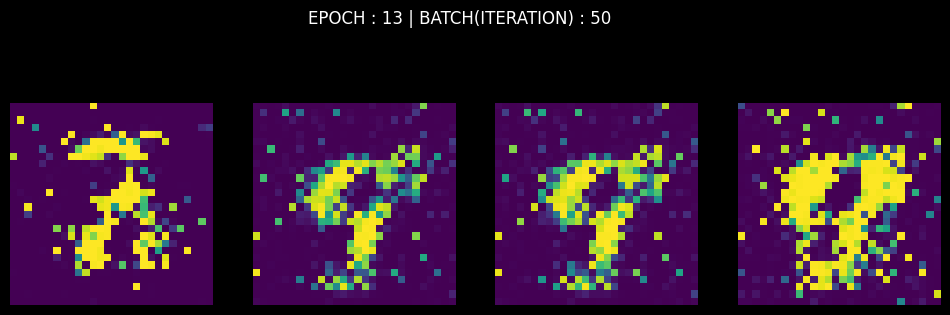

[Epoch: 13/50] [Batch: 235/235] [D loss: 0.406730] [G loss: 3.555797]


  0%|          | 0/235 [00:00<?, ?it/s]

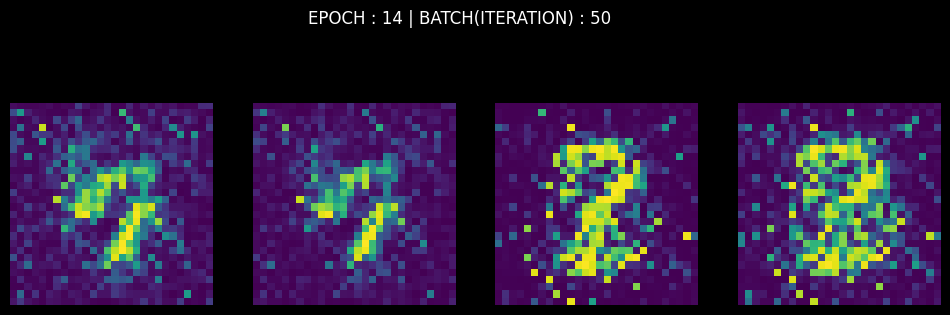

[Epoch: 14/50] [Batch: 235/235] [D loss: 0.260976] [G loss: 1.444590]


  0%|          | 0/235 [00:00<?, ?it/s]

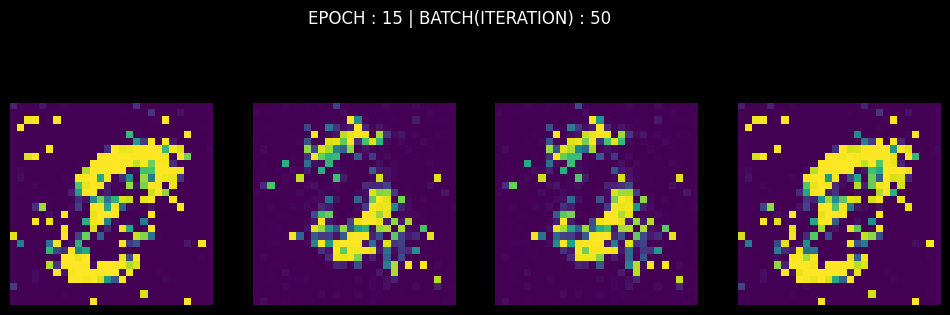

[Epoch: 15/50] [Batch: 235/235] [D loss: 1.384325] [G loss: 6.055236]


  0%|          | 0/235 [00:00<?, ?it/s]

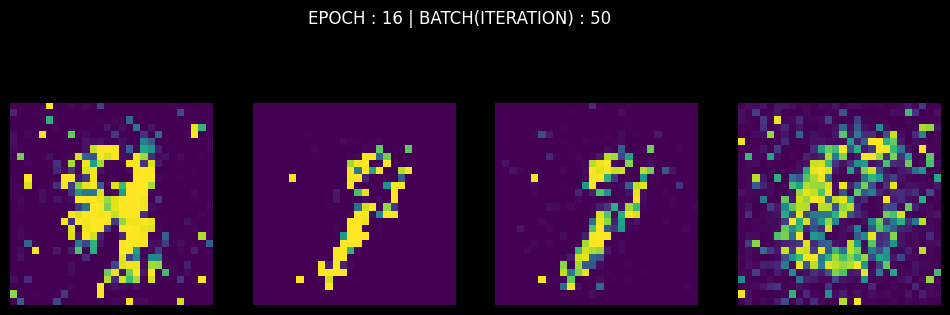

[Epoch: 16/50] [Batch: 235/235] [D loss: 0.304191] [G loss: 1.061625]


  0%|          | 0/235 [00:00<?, ?it/s]

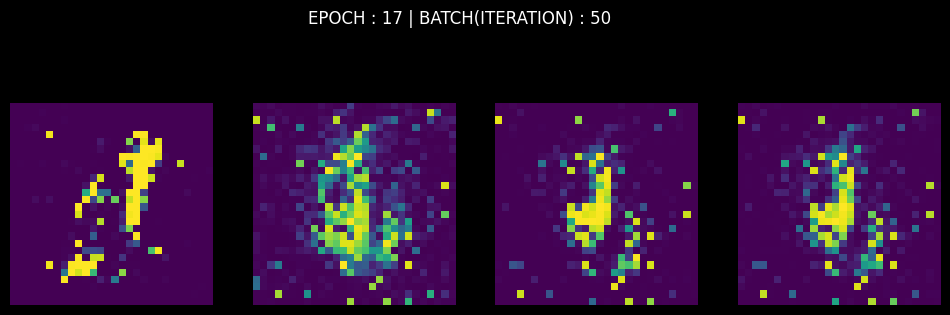

[Epoch: 17/50] [Batch: 235/235] [D loss: 0.289643] [G loss: 1.499878]


  0%|          | 0/235 [00:00<?, ?it/s]

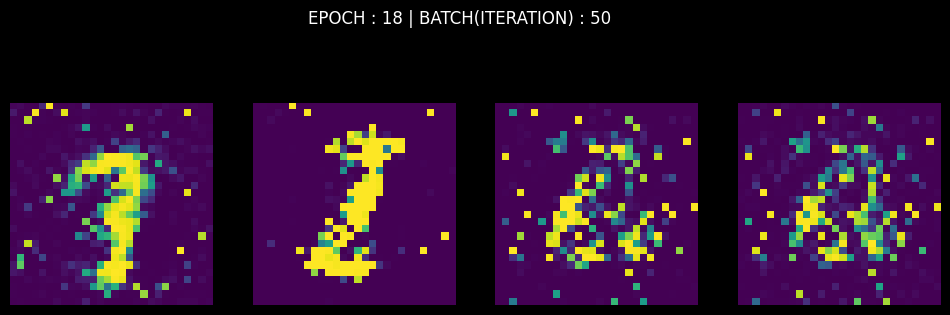

[Epoch: 18/50] [Batch: 235/235] [D loss: 0.267445] [G loss: 2.710521]


  0%|          | 0/235 [00:00<?, ?it/s]

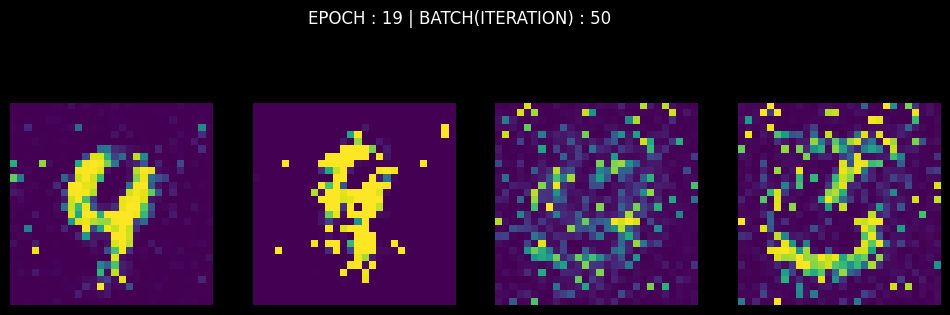

[Epoch: 19/50] [Batch: 235/235] [D loss: 0.409462] [G loss: 0.806434]


  0%|          | 0/235 [00:00<?, ?it/s]

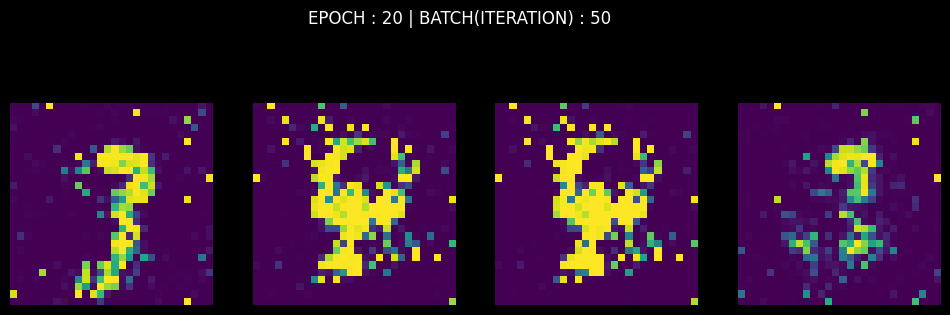

[Epoch: 20/50] [Batch: 235/235] [D loss: 0.342529] [G loss: 2.645136]


  0%|          | 0/235 [00:00<?, ?it/s]

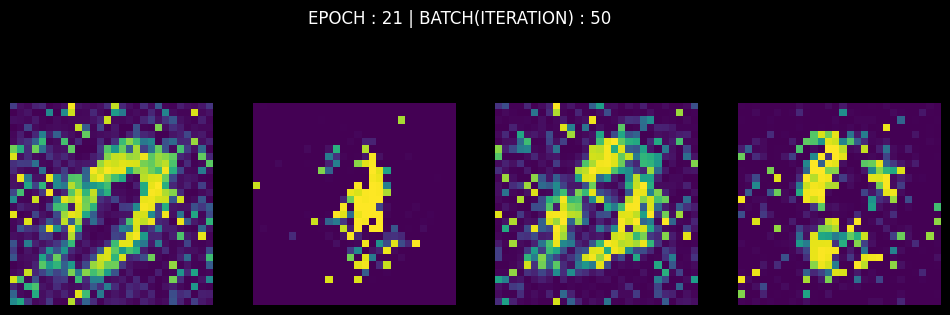

[Epoch: 21/50] [Batch: 235/235] [D loss: 0.300236] [G loss: 1.210591]


  0%|          | 0/235 [00:00<?, ?it/s]

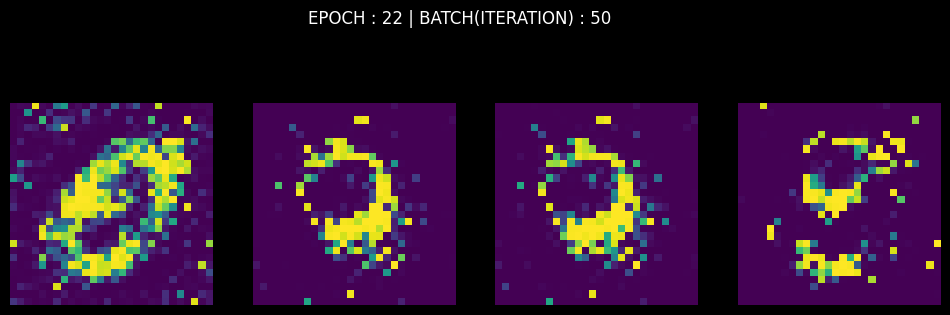

[Epoch: 22/50] [Batch: 235/235] [D loss: 0.246879] [G loss: 1.913103]


  0%|          | 0/235 [00:00<?, ?it/s]

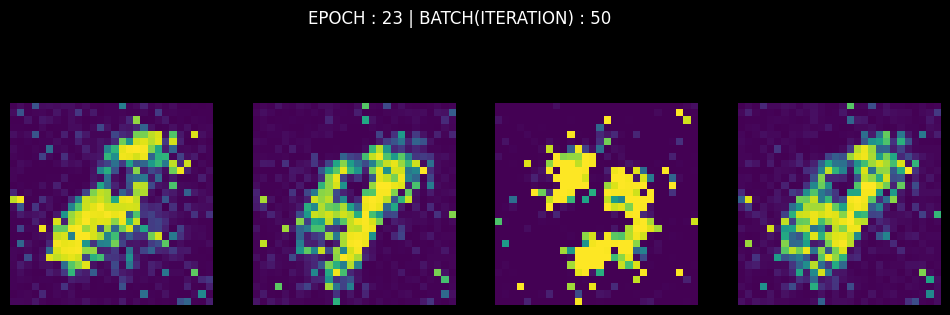

[Epoch: 23/50] [Batch: 235/235] [D loss: 0.146401] [G loss: 2.018420]


  0%|          | 0/235 [00:00<?, ?it/s]

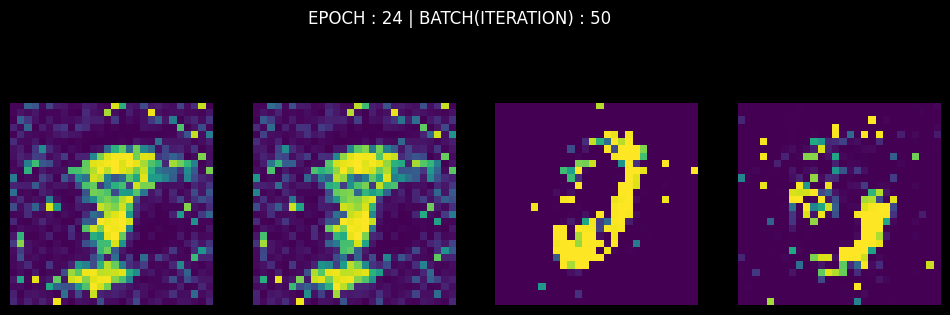

[Epoch: 24/50] [Batch: 235/235] [D loss: 0.332751] [G loss: 0.936865]


  0%|          | 0/235 [00:00<?, ?it/s]

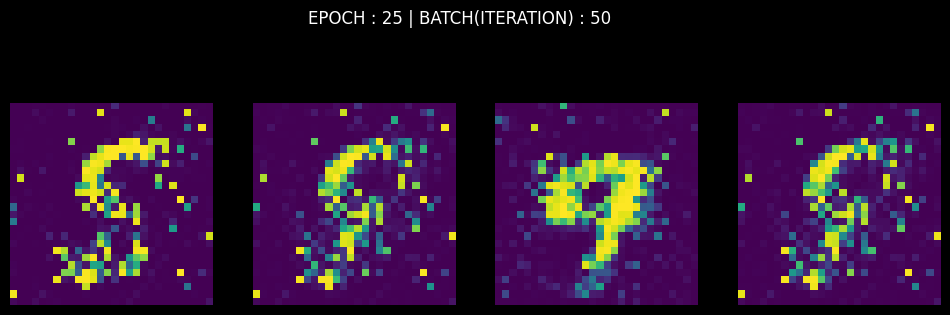

[Epoch: 25/50] [Batch: 235/235] [D loss: 0.231110] [G loss: 1.443857]


  0%|          | 0/235 [00:00<?, ?it/s]

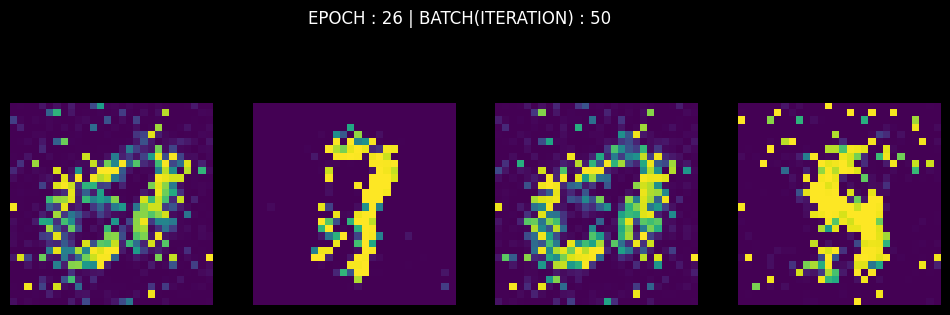

[Epoch: 26/50] [Batch: 235/235] [D loss: 0.460618] [G loss: 2.961246]


  0%|          | 0/235 [00:00<?, ?it/s]

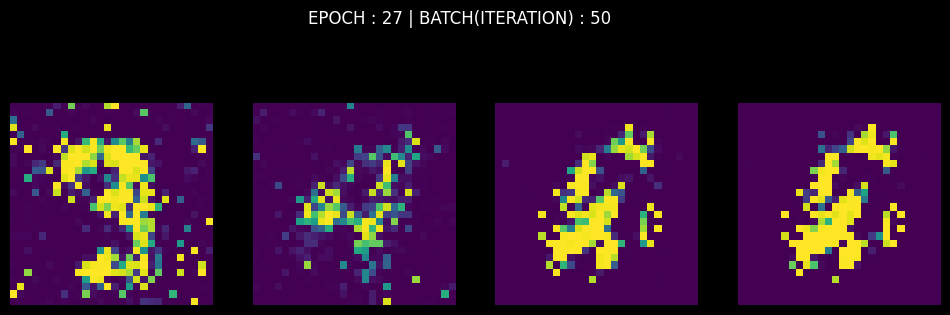

[Epoch: 27/50] [Batch: 235/235] [D loss: 0.294791] [G loss: 1.245628]


  0%|          | 0/235 [00:00<?, ?it/s]

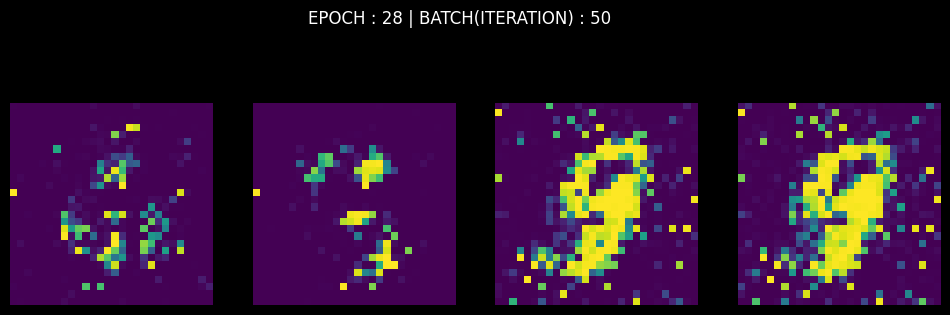

[Epoch: 28/50] [Batch: 235/235] [D loss: 0.212259] [G loss: 1.521058]


  0%|          | 0/235 [00:00<?, ?it/s]

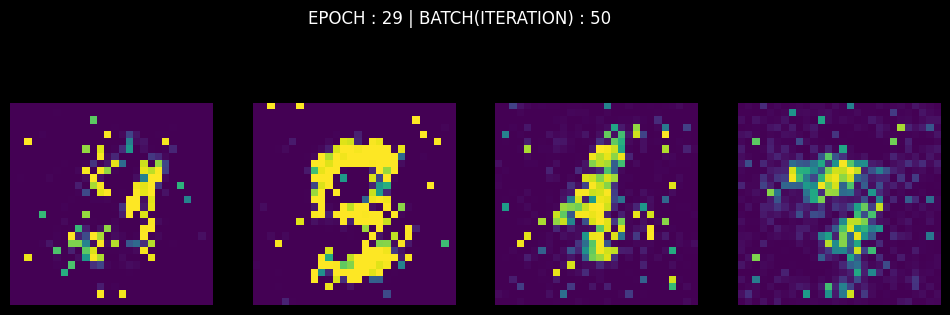

[Epoch: 29/50] [Batch: 235/235] [D loss: 0.352763] [G loss: 4.534869]


  0%|          | 0/235 [00:00<?, ?it/s]

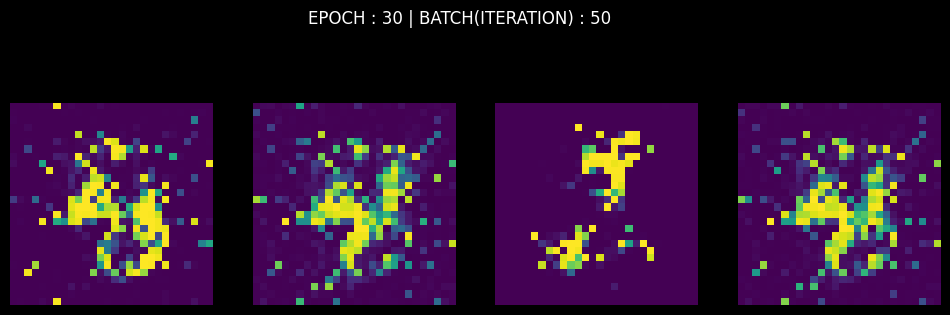

[Epoch: 30/50] [Batch: 235/235] [D loss: 0.231904] [G loss: 1.419658]


  0%|          | 0/235 [00:00<?, ?it/s]

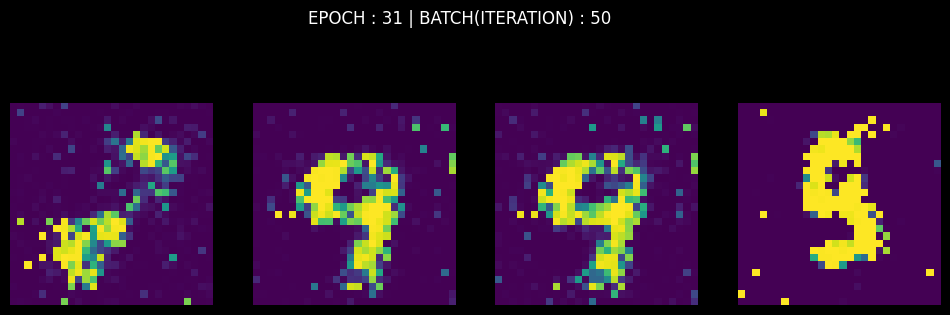

[Epoch: 31/50] [Batch: 235/235] [D loss: 0.207430] [G loss: 1.744282]


  0%|          | 0/235 [00:00<?, ?it/s]

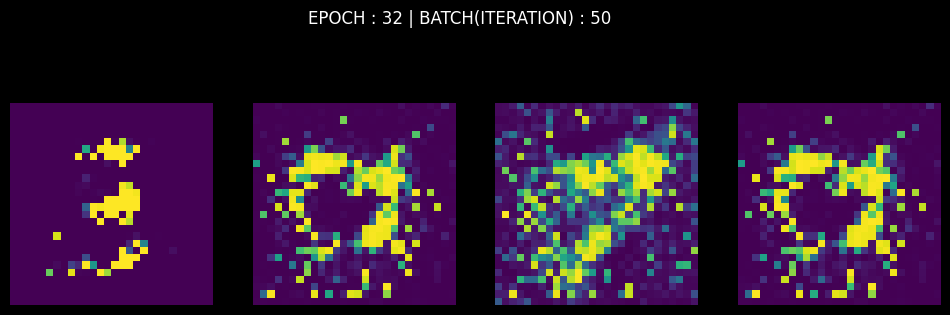

[Epoch: 32/50] [Batch: 235/235] [D loss: 0.229734] [G loss: 1.516162]


  0%|          | 0/235 [00:00<?, ?it/s]

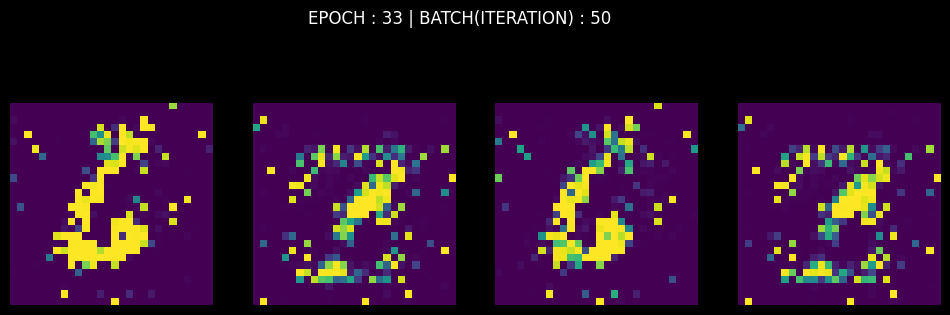

[Epoch: 33/50] [Batch: 235/235] [D loss: 0.287973] [G loss: 3.031681]


  0%|          | 0/235 [00:00<?, ?it/s]

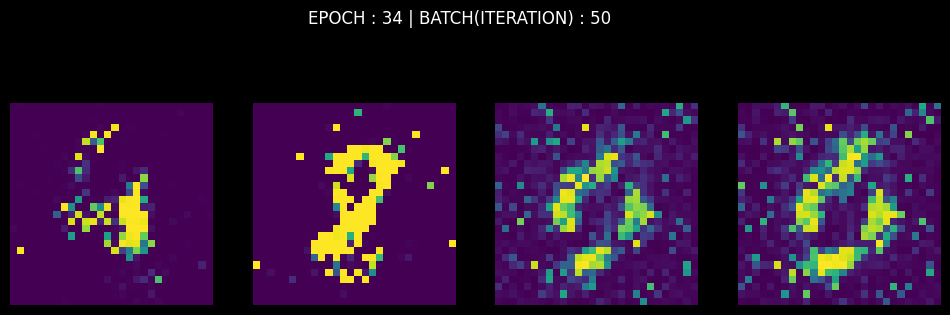

[Epoch: 34/50] [Batch: 235/235] [D loss: 0.176769] [G loss: 1.773412]


  0%|          | 0/235 [00:00<?, ?it/s]

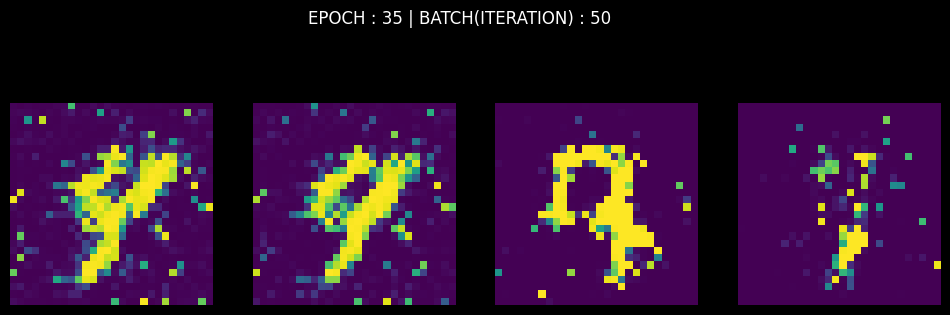

[Epoch: 35/50] [Batch: 235/235] [D loss: 0.276478] [G loss: 4.136407]


  0%|          | 0/235 [00:00<?, ?it/s]

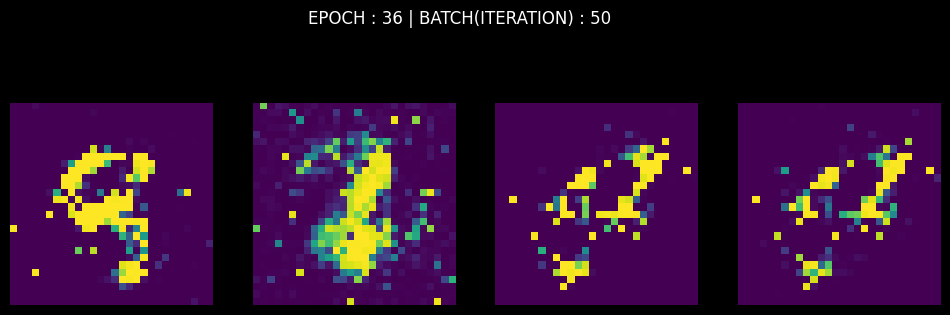

[Epoch: 36/50] [Batch: 235/235] [D loss: 0.208169] [G loss: 3.007386]


  0%|          | 0/235 [00:00<?, ?it/s]

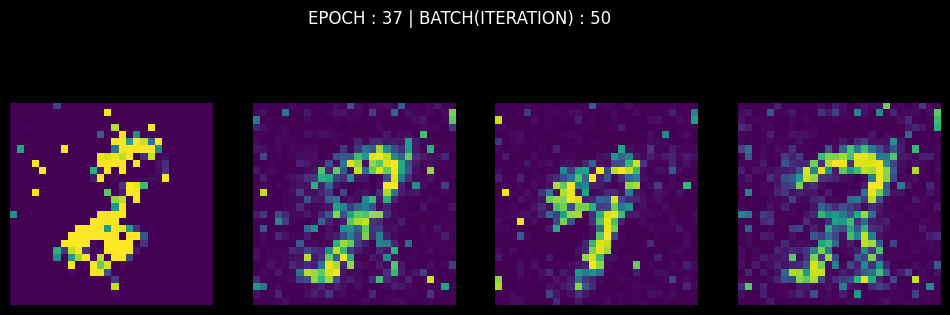

[Epoch: 37/50] [Batch: 235/235] [D loss: 0.134064] [G loss: 2.363955]


  0%|          | 0/235 [00:00<?, ?it/s]

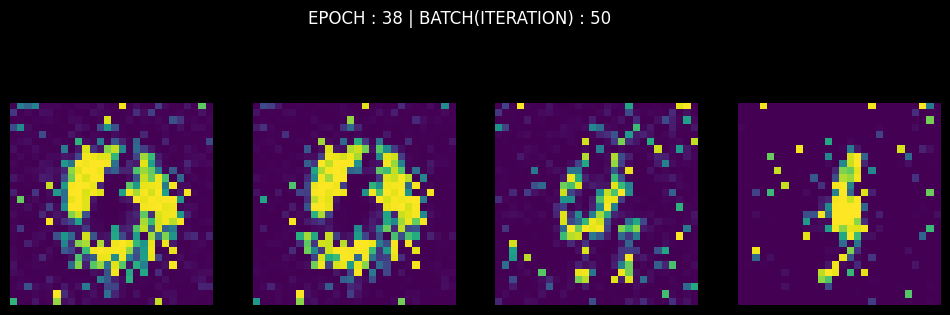

[Epoch: 38/50] [Batch: 235/235] [D loss: 0.168632] [G loss: 1.818308]


  0%|          | 0/235 [00:00<?, ?it/s]

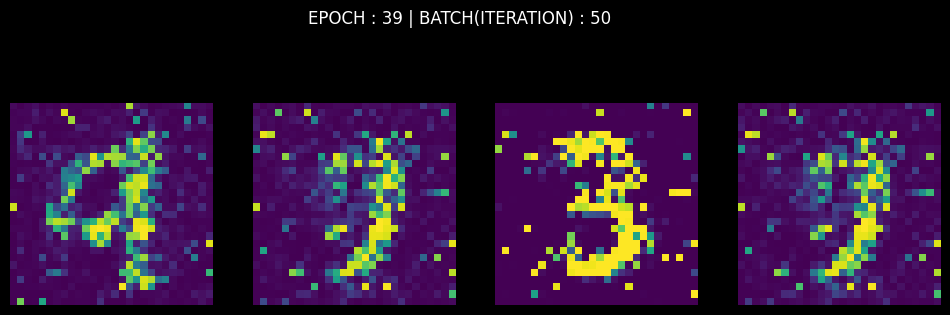

[Epoch: 39/50] [Batch: 235/235] [D loss: 0.089219] [G loss: 3.527403]


  0%|          | 0/235 [00:00<?, ?it/s]

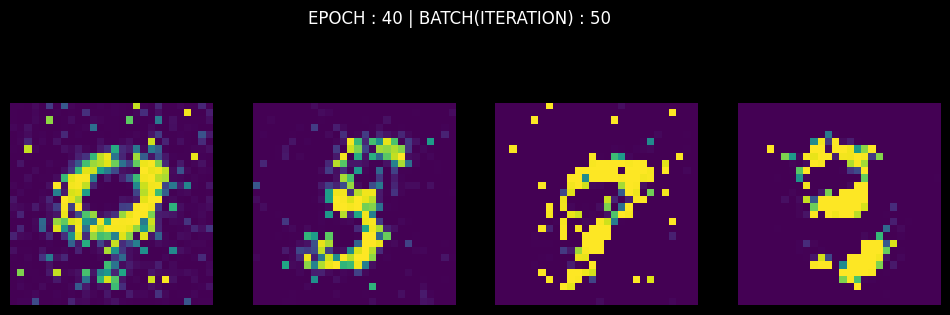

[Epoch: 40/50] [Batch: 235/235] [D loss: 0.101162] [G loss: 2.462052]


  0%|          | 0/235 [00:00<?, ?it/s]

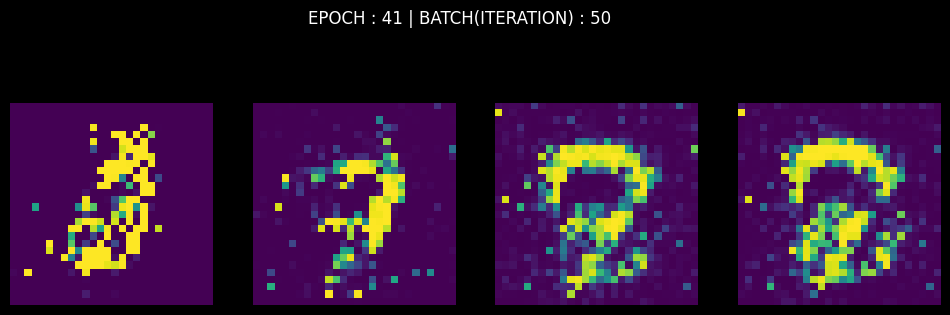

[Epoch: 41/50] [Batch: 235/235] [D loss: 0.195249] [G loss: 2.740340]


  0%|          | 0/235 [00:00<?, ?it/s]

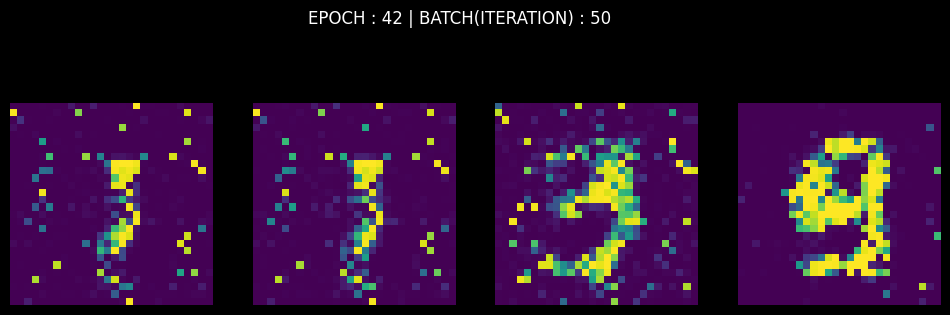

[Epoch: 42/50] [Batch: 235/235] [D loss: 0.152041] [G loss: 2.936144]


  0%|          | 0/235 [00:00<?, ?it/s]

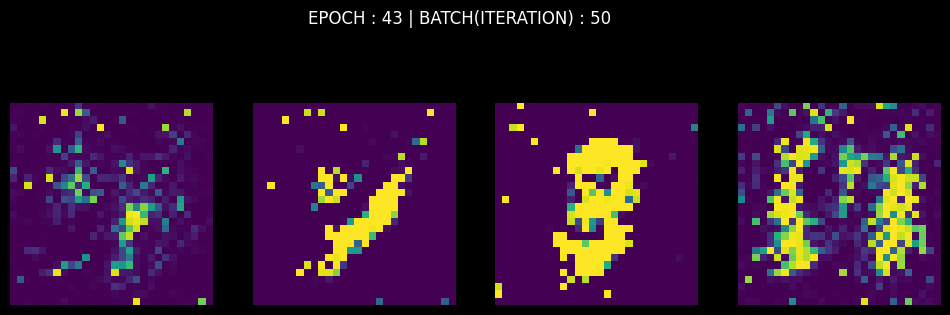

[Epoch: 43/50] [Batch: 235/235] [D loss: 0.222515] [G loss: 2.882919]


  0%|          | 0/235 [00:00<?, ?it/s]

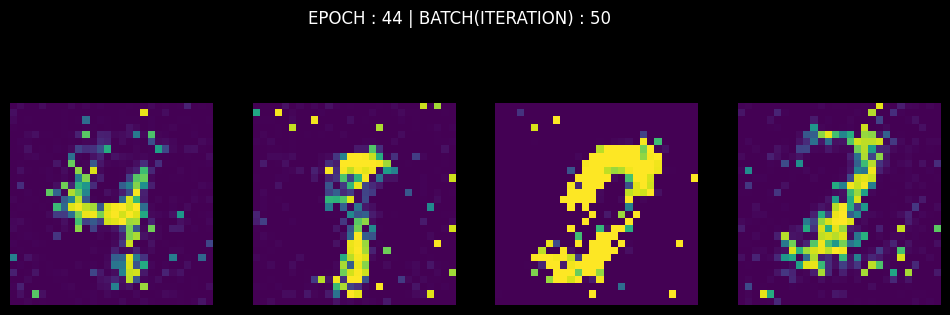

[Epoch: 44/50] [Batch: 235/235] [D loss: 0.320865] [G loss: 3.105591]


  0%|          | 0/235 [00:00<?, ?it/s]

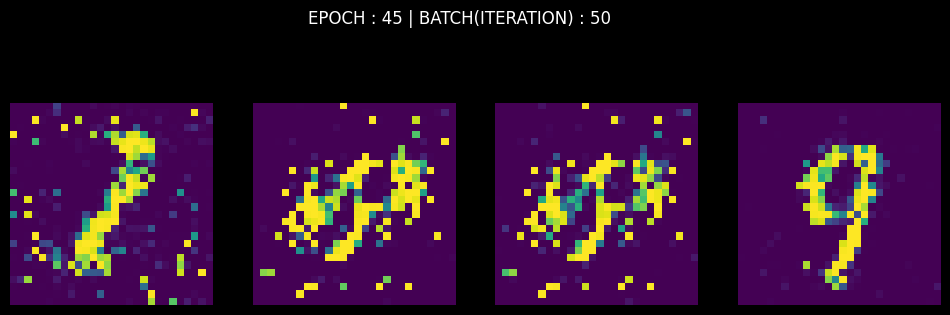

[Epoch: 45/50] [Batch: 235/235] [D loss: 0.137827] [G loss: 1.684408]


  0%|          | 0/235 [00:00<?, ?it/s]

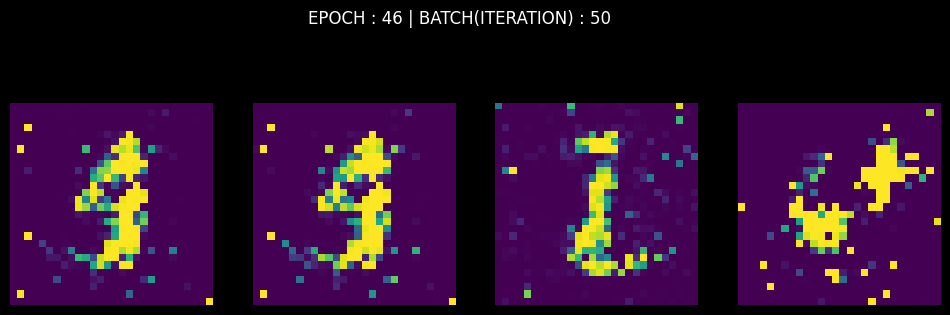

[Epoch: 46/50] [Batch: 235/235] [D loss: 0.152099] [G loss: 1.938869]


  0%|          | 0/235 [00:00<?, ?it/s]

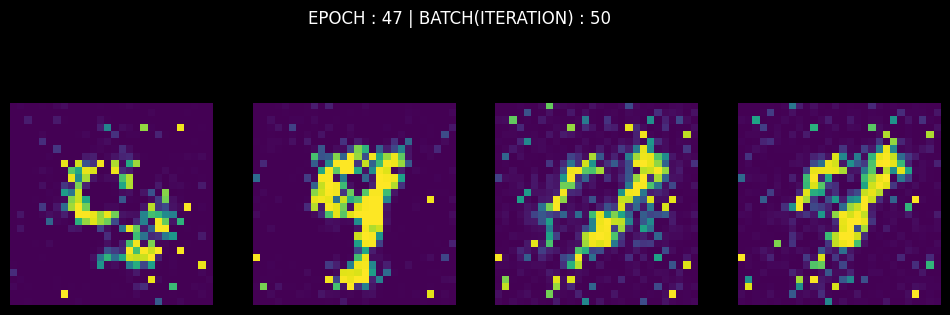

[Epoch: 47/50] [Batch: 235/235] [D loss: 0.197913] [G loss: 2.435791]


  0%|          | 0/235 [00:00<?, ?it/s]

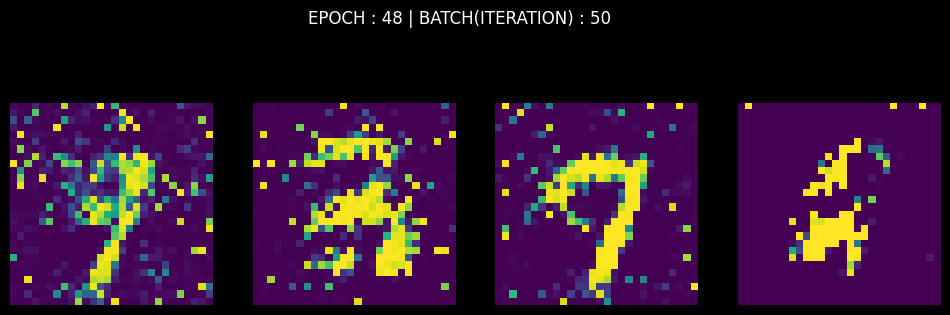

[Epoch: 48/50] [Batch: 235/235] [D loss: 0.202292] [G loss: 3.181056]


  0%|          | 0/235 [00:00<?, ?it/s]

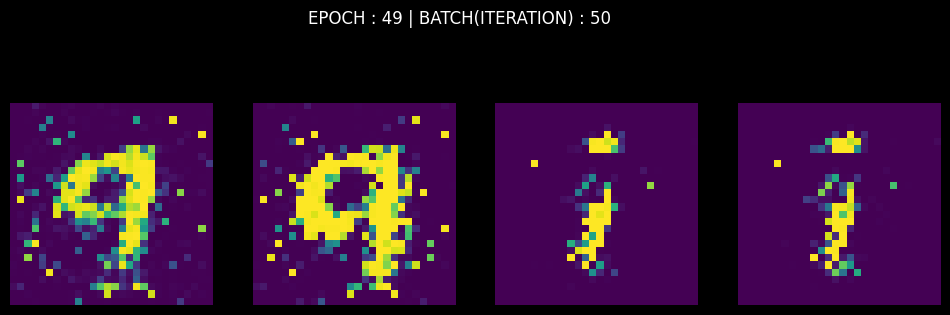

[Epoch: 49/50] [Batch: 235/235] [D loss: 0.196527] [G loss: 1.741687]


  0%|          | 0/235 [00:00<?, ?it/s]

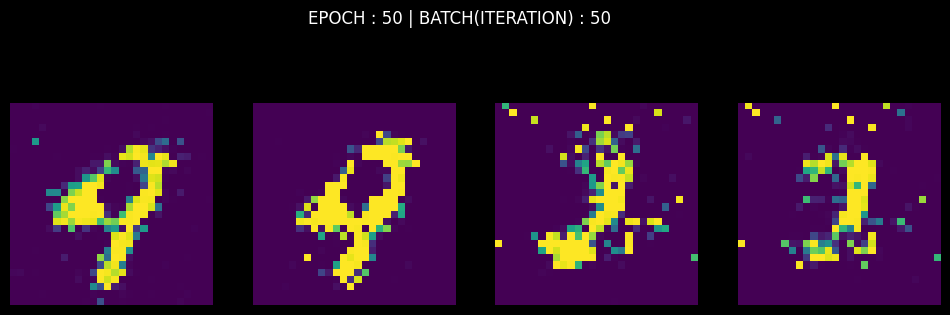

[Epoch: 50/50] [Batch: 235/235] [D loss: 0.105567] [G loss: 2.695171]


In [57]:
n_epochs = 50  # suggested default = 200
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(
            tqdm(dataloader)):  # This code(enumerate) is dealt with once more in the *TEST_CODE below.
        # Used 'tqdm' for showing progress

        # Adversarial ground truths (For more detail, refer *Read_More below)
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0),
                         requires_grad=False)  # imgs.size(0) == batch_size(1 batch) == 64, *TEST_CODE
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0),
                        requires_grad=False)  # And Variable is for caclulate gradient. In fact, you can use it, but you don't have to.
        # requires_grad=False is default in tensor type. *Read_More

        # Configure input
        real_imgs = imgs.type(Tensor)  # As mentioned, it is no longer necessary to wrap the tensor in a Variable.
        # real_imgs = Variable(imgs.type(Tensor)) # requires_grad=False, Default! It's same.

        # ------------
        # Train Generator
        # ------------
        optimizer_G.zero_grad()

        # sample noise 'z' as generator input
        z = Tensor(np.random.normal(0, 1, (
        imgs.shape[0], latent_dim)))  # Random sampling Tensor(batch_size, latent_dim) of Gaussian distribution
        # z.shape == torch.Size([64, 100])

        # Generate a batch of images
        gen_imgs = generator(z)
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs),
                                  valid)  # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)

        g_loss.backward()
        optimizer_G.step()

        # ------------
        # Train Discriminator
        # ------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs),
                                     valid)  # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()),
                                     fake)  # We are learning the discriminator now. So have to use detach()

        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()  # If didn't use detach() for gen_imgs, all weights of the generator will be calculated with backward().
        optimizer_D.step()

        # ------------
        # Real Time Visualization (While Training)
        # ------------
        if ((i + 1) % sample_interval) == 50:
            sample_z_in_train = Tensor(np.random.normal(0, 1, (6, latent_dim)))
            # z.shape == torch.Size([64, 100])
            sample_gen_imgs_in_train = generator(sample_z_in_train)
            # gen_imgs.shape == torch.Size([64, 1, 28, 28])

            display_images(None, sample_gen_imgs_in_train, epoch=epoch, iteration=i)
    print("[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
          % (epoch + 1, n_epochs, i + 1, len(dataloader), d_loss.item(), g_loss.item())
          )


### Свертка

Свертка - операция над парой матриц $A$ (размера $n_x\times n_y$) и $B$ (размера $m_x \times m_y$), результатом которой является матрица $C = A * B$ размера $(n_x-m_x+1)\times (n_y-m_y+1)$.
Каждый элемент результата вычисляется как скалярное произведение матрицы $B$ и некоторой подматрицы $A$ такого же размера (подматрица определяется положением элемента в результате).
То есть, $C_{i,j} = \sum_{u = 0}^{m_x-1}\sum_{v = 0}^{m_y - 1}A_{i+u,j+v}B_{u,v}$. На рисунке можно видеть, как матрица <math>B</math> «двигается» по матрице <math>A</math>, и в каждом положении считается скалярное произведение матрицы <math>B</math> и той части матрицы <math>A</math>, на которую она сейчас наложена. Получившееся число записывается в соответствующий элемент результата.

Логический смысл свертки такой - чем больше величина элемента свертки, тем больше эта часть матрицы $A$ была похожа на матрицу $B$ (похожа в смысле скалярного произведения). Поэтому матрицу $A$ называют ''изображением'', а матрицу $B$ - фильтром.

Особенностью свёрточного слоя является сравнительно небольшое количество параметров, устанавливаемое при обучении. Так например, если исходное изображение имеет размерность 100×100 пикселей по трём каналам (это значит 30 000 входных нейронов), а свёрточный слой использует фильтры c ядром 3×3 пикселя и таких ядер 6, тогда в процессе обучения определяется только 9 весов ядра, однако по всем сочетаниям фильтров, то есть 9×3×6=162, в таком случае данный слой требует нахождения только 162 параметров, что существенно меньше количества искомых параметров полносвязной нейронной сети. 

![conv](https://raw.githubusercontent.com/sswt/dive2gai/main/unit2/data/convolution_with_filter.gif)

### Субдискретизация (Pooling)

Слой пулинга представляет собой нелинейное уплотнение карты признаков, при этом группа пикселей (обычно размера 2×2) уплотняется до одного пикселя, проходя нелинейное преобразование. Наиболее употребительна при этом функция максимума. Пулинг интерпретируется так: если на предыдущей операции свёртки уже были выявлены некоторые признаки, то для дальнейшей обработки настолько подробное изображение уже не нужно, и оно уплотняется до менее подробного.  К тому же фильтрация уже ненужных деталей помогает не переобучаться.  Два популярных примера подобных операций: получение максимального значения (max pooling) и получение среднего значения (average pooling).


Слой субдискретизации имеет два параметра: размер фильтра $K$ и шаг $S$ (stride). 

Формула размера стороны будет $\displaystyle N' = 1+ \frac{N-K}{S}.$

Ниже приведён пример использования операций max pooling и average pooling при обработке массива.

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/subdiscretization_pooling.png" width="600">

In [4]:
# create tensor 4x4
# fmt: off
input = torch.tensor([[[[1, 1, 2, 4],
                        [5, 6, 7, 8],
                        [3, 2, 1, 0],
                        [1, 2, 3, 4]]]], dtype=torch.float)
# fmt: on

max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
avg_pool = torch.nn.AvgPool2d(kernel_size=2, stride=2)

print("Input:\n", input)
print("Max pooling:\n", max_pool(input))
print("Average pooling:\n", avg_pool(input))

Input:
 tensor([[[[1., 1., 2., 4.],
          [5., 6., 7., 8.],
          [3., 2., 1., 0.],
          [1., 2., 3., 4.]]]])
Max pooling:
 tensor([[[[6., 8.],
          [3., 4.]]]])
Average pooling:
 tensor([[[[3.2500, 5.2500],
          [2.0000, 2.0000]]]])


### Способы повышения разрешения — Upsampling
Самый простой способ — выполнить повышение разрешения с помощью **интерполяции**. В PyTorch это осуществляется слоем [Upsample](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html)

In [58]:

x = torch.rand((1, 3, 10, 10))  # one 3-channal image with 10x10 size
print("Input shape:", x.shape)

upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
y = upsample(x)

print("Output shape", y.shape)

Input shape: torch.Size([1, 3, 10, 10])
Output shape torch.Size([1, 3, 20, 20])


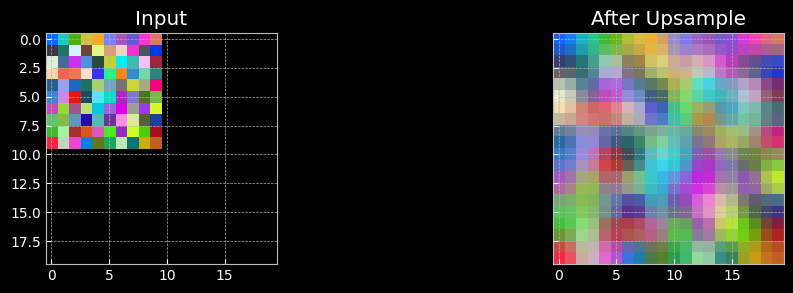

In [59]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].imshow((x[0].permute(1, 2, 0) * 256).detach().numpy().astype(np.uint8))
ax[1].imshow((y[0].permute(1, 2, 0).detach().numpy() * 256).astype(np.uint8))
ax[0].set_title("Input")
ax[1].set_title("After Upsample")
plt.show()

### Transposed Convolution Layer
ansposed convolution проходит по всем пикселям входа и умножает их на обучаемое ядро свертки. При этом каждый одиночный пиксель превращается в фрагмент. Там, где фрагменты накладываются друг на друга, значения попиксельно суммируются.

Используя Transposed convolution с параметром `stride = 2`, можно повышать размер карты признаков приблизительно в два раза, добавляя на нее мелкие детали.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/L14/out/transposed_convolution_explained.png" width="1024"></center>

<center><em>Transposed convolution</em></center>

In [4]:
import torch
from torch import nn
x = torch.rand((1, 3, 2, 2)) * 255  # one 3-channel image with 10x10 size
print(x.shape)

torch.Size([1, 3, 2, 2])


In [5]:
convT = nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=4, stride=2)
y = convT(x)
print(y.shape)  # One 3-chanells image with 12x12 size

torch.Size([1, 3, 6, 6])


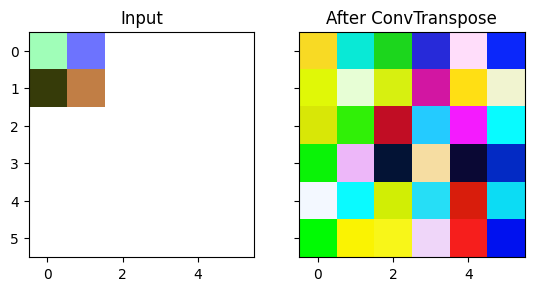

In [7]:
from matplotlib import pyplot as plt
import numpy as np
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].imshow(x[0].permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[1].imshow(y[0].permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[0].set_title("Input")
ax[1].set_title("After ConvTranspose")
plt.show()

# DCGAN

Это обычный ган, в котором генератор и дискриминатора представляет собой глубокие сверточные сети, что логично для обработки изображений. Однако есть несколько важных особенностей, которые стоит иметь в виду, если вы сами захотите применить GAN к тем или иным картинкам:
* вместо субдискретизации используются дополнительные сверточные уровни, в которых свертки участвуют с пробелами (strided convolutions)
* полносвязные скрытые слои тоже не используются.
* нормализация по мини-батчам используется как в генераторе, так и в дискриминаторе
* В генераторе везде Relu, в дискриминаторе протекающий Relu (LeakyRelu)

![GAN](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FpMdme%2FbtqA1ArBCOy%2FqqGg7IvV0hpqVkvBuEFpJK%2Fimg.png)

## Архитектура
![dccgan](https://raw.githubusercontent.com/sswt/dive2gai/main/unit2/data/dcgan-gen.png)

<center><img src ="https://edunet.kea.su/repo/EduNet-content/L14/out/dcgan_architecture.png" width="700"></center>
<center><em>Зеркальная архитектура DCGAN </em></center>

In [61]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img
summary(Generator().to(device), (1,100))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 1, 28, 28]            --
├─Sequential: 1-1                        [1, 6272]                 --
│    └─Linear: 2-1                       [1, 6272]                 633,472
├─Sequential: 1-2                        [1, 1, 28, 28]            --
│    └─BatchNorm2d: 2-2                  [1, 128, 7, 7]            256
│    └─Upsample: 2-3                     [1, 128, 14, 14]          --
│    └─Conv2d: 2-4                       [1, 128, 14, 14]          147,584
│    └─BatchNorm2d: 2-5                  [1, 128, 14, 14]          256
│    └─LeakyReLU: 2-6                    [1, 128, 14, 14]          --
│    └─Upsample: 2-7                     [1, 128, 28, 28]          --
│    └─Conv2d: 2-8                       [1, 64, 28, 28]           73,792
│    └─BatchNorm2d: 2-9                  [1, 64, 28, 28]           128
│    └─LeakyReLU: 2-10                   [1, 64, 28, 28]           -

In [63]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters):
            block = [
                nn.Conv2d(in_filters, out_filters, 4, 2, 0),
                nn.BatchNorm2d(out_filters),
                nn.LeakyReLU(0.2, inplace=True)
                ]
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 64),
            *discriminator_block(64, 128),
        )
        self.adv_layer = nn.Sequential(
                nn.Conv2d(128, 1, 4, 2, 0),
                nn.Sigmoid()
            )

    def forward(self, img):
        out = self.model(img)
        validity = self.adv_layer(out)

        return validity

summary(Discriminator().to(device), (1, 1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1, 1, 1]              --
├─Sequential: 1-1                        [1, 128, 5, 5]            --
│    └─Conv2d: 2-1                       [1, 64, 13, 13]           1,088
│    └─BatchNorm2d: 2-2                  [1, 64, 13, 13]           128
│    └─LeakyReLU: 2-3                    [1, 64, 13, 13]           --
│    └─Conv2d: 2-4                       [1, 128, 5, 5]            131,200
│    └─BatchNorm2d: 2-5                  [1, 128, 5, 5]            256
│    └─LeakyReLU: 2-6                    [1, 128, 5, 5]            --
├─Sequential: 1-2                        [1, 1, 1, 1]              --
│    └─Conv2d: 2-7                       [1, 1, 1, 1]              2,049
│    └─Sigmoid: 2-8                      [1, 1, 1, 1]              --
Total params: 134,721
Trainable params: 134,721
Non-trainable params: 0
Total mult-adds (M): 3.47
Input size (MB): 0.00
Forward/backward pass 

In [68]:
adversarial_loss = torch.nn.BCELoss()
generator = Generator()
discriminator = Discriminator()
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [69]:
b1 = 0.5
b2 = 0.999

lr = 0.0002


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1,b2))

  0%|          | 0/235 [00:00<?, ?it/s]

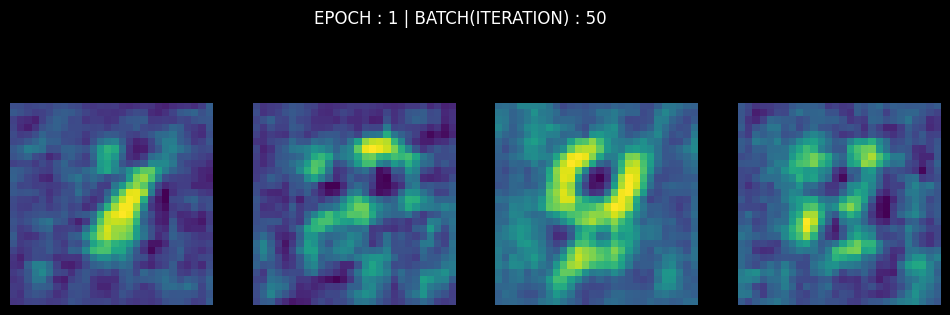

[Epoch: 1/25] [Batch: 235/235] [D loss: 0.384817] [G loss: 1.028910]


  0%|          | 0/235 [00:00<?, ?it/s]

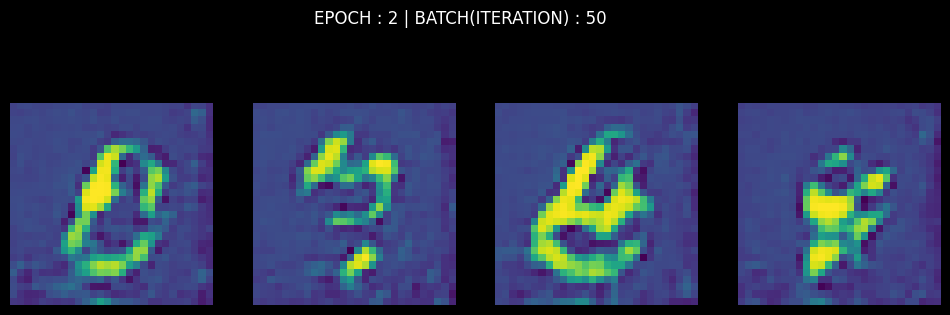

[Epoch: 2/25] [Batch: 235/235] [D loss: 0.372794] [G loss: 2.092552]


  0%|          | 0/235 [00:00<?, ?it/s]

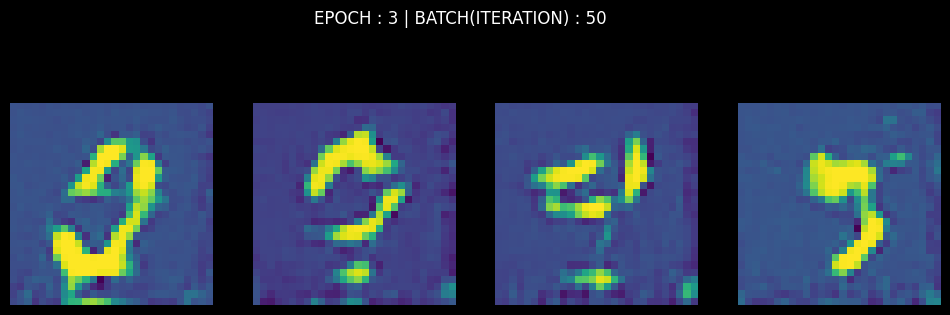

[Epoch: 3/25] [Batch: 235/235] [D loss: 0.460100] [G loss: 0.683149]


  0%|          | 0/235 [00:00<?, ?it/s]

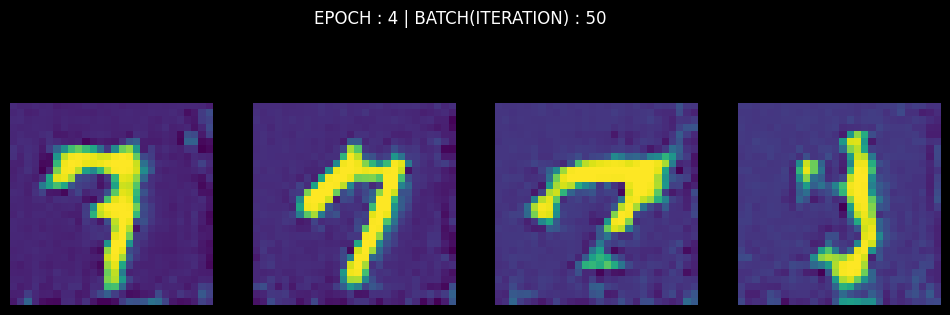

[Epoch: 4/25] [Batch: 235/235] [D loss: 0.265422] [G loss: 2.588226]


  0%|          | 0/235 [00:00<?, ?it/s]

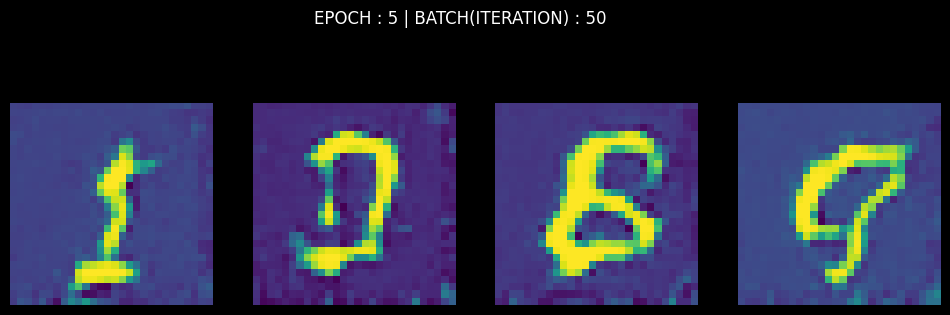

[Epoch: 5/25] [Batch: 235/235] [D loss: 0.270984] [G loss: 1.811181]


  0%|          | 0/235 [00:00<?, ?it/s]

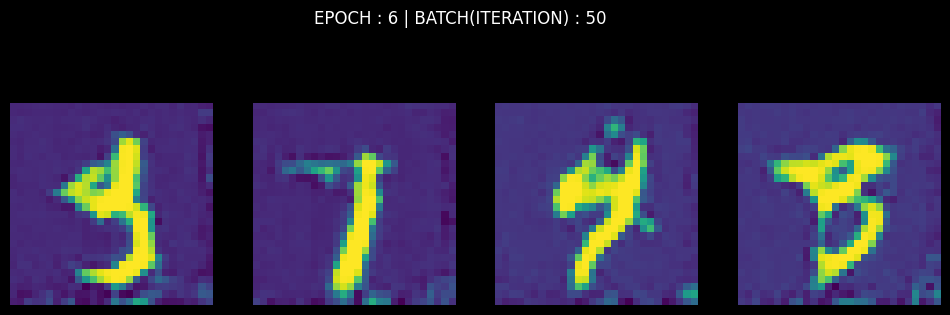

[Epoch: 6/25] [Batch: 235/235] [D loss: 0.200522] [G loss: 1.989507]


  0%|          | 0/235 [00:00<?, ?it/s]

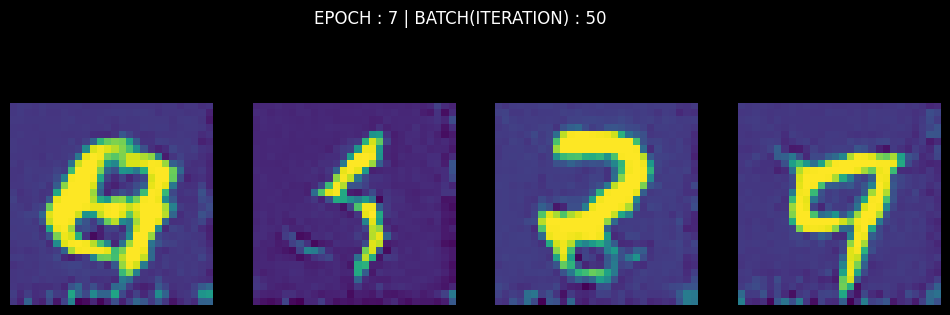

[Epoch: 7/25] [Batch: 235/235] [D loss: 0.250272] [G loss: 1.412779]


  0%|          | 0/235 [00:00<?, ?it/s]

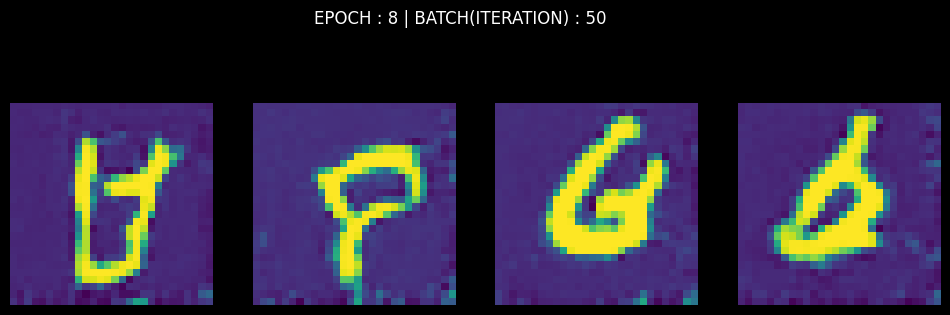

[Epoch: 8/25] [Batch: 235/235] [D loss: 0.310530] [G loss: 1.635036]


  0%|          | 0/235 [00:00<?, ?it/s]

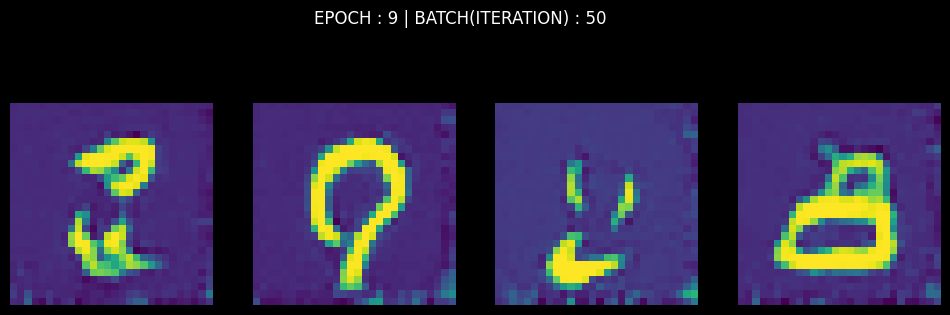

[Epoch: 9/25] [Batch: 235/235] [D loss: 0.266002] [G loss: 2.128572]


  0%|          | 0/235 [00:00<?, ?it/s]

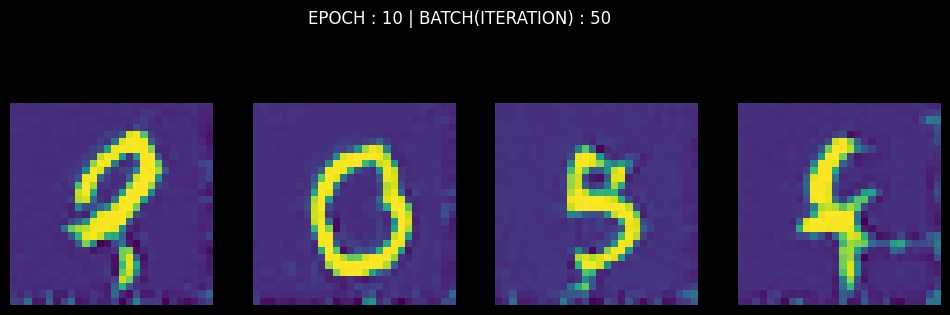

[Epoch: 10/25] [Batch: 235/235] [D loss: 0.375038] [G loss: 1.634393]


  0%|          | 0/235 [00:00<?, ?it/s]

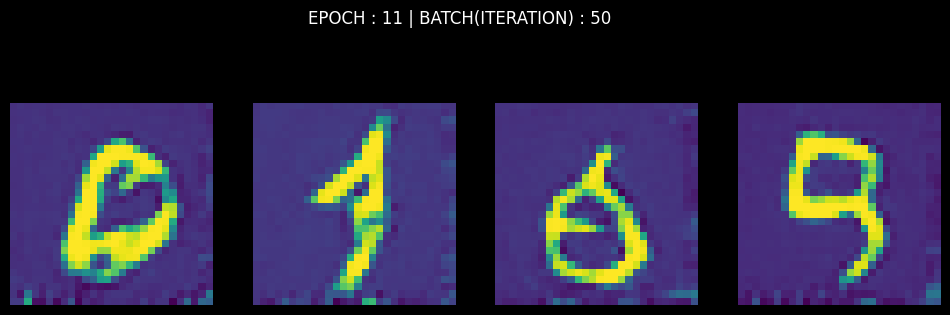

[Epoch: 11/25] [Batch: 235/235] [D loss: 0.227695] [G loss: 3.311661]


  0%|          | 0/235 [00:00<?, ?it/s]

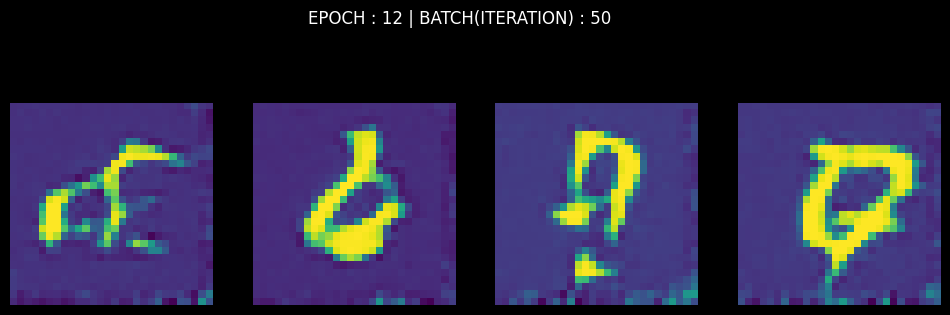

[Epoch: 12/25] [Batch: 235/235] [D loss: 0.281810] [G loss: 1.259182]


  0%|          | 0/235 [00:00<?, ?it/s]

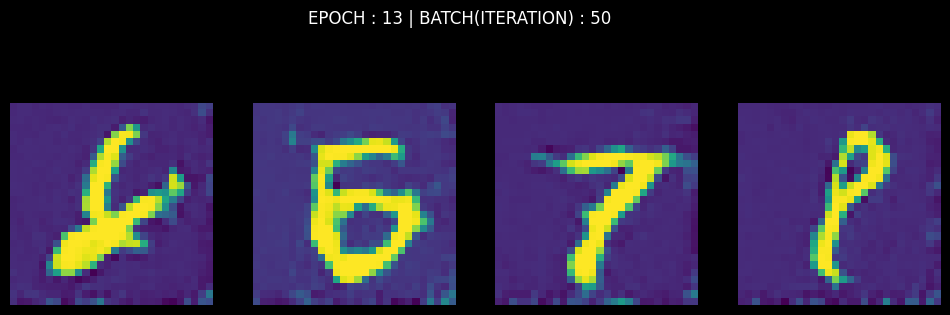

[Epoch: 13/25] [Batch: 235/235] [D loss: 0.553762] [G loss: 1.026796]


  0%|          | 0/235 [00:00<?, ?it/s]

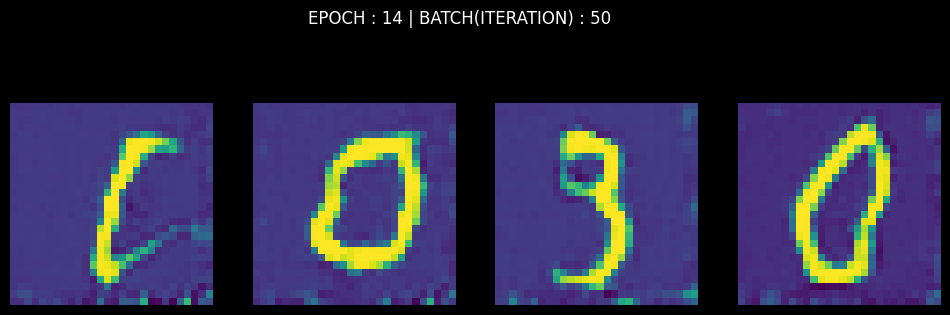

[Epoch: 14/25] [Batch: 235/235] [D loss: 0.265878] [G loss: 1.381265]


  0%|          | 0/235 [00:00<?, ?it/s]

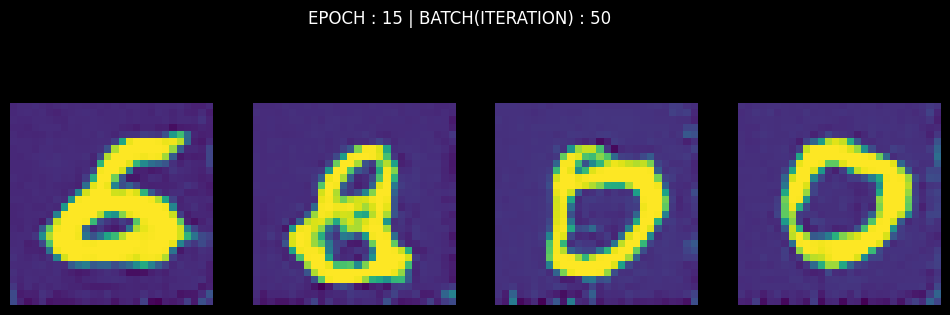

[Epoch: 15/25] [Batch: 235/235] [D loss: 0.195231] [G loss: 1.862537]


  0%|          | 0/235 [00:00<?, ?it/s]

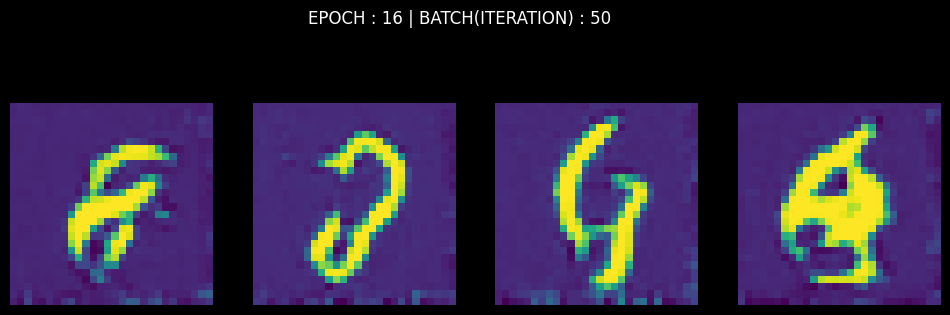

[Epoch: 16/25] [Batch: 235/235] [D loss: 0.321806] [G loss: 1.293054]


  0%|          | 0/235 [00:00<?, ?it/s]

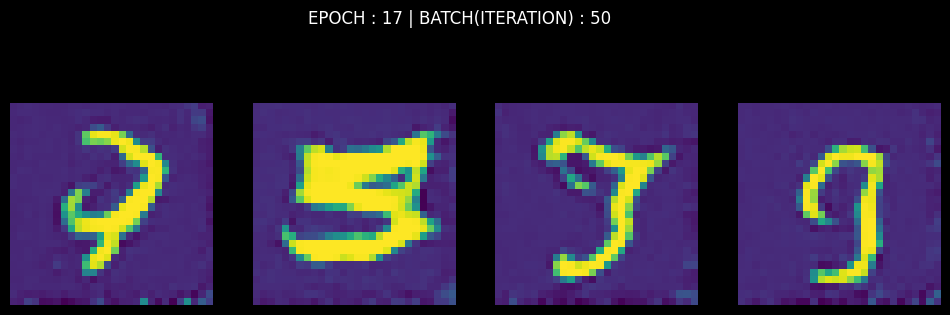

[Epoch: 17/25] [Batch: 235/235] [D loss: 0.199443] [G loss: 2.108269]


  0%|          | 0/235 [00:00<?, ?it/s]

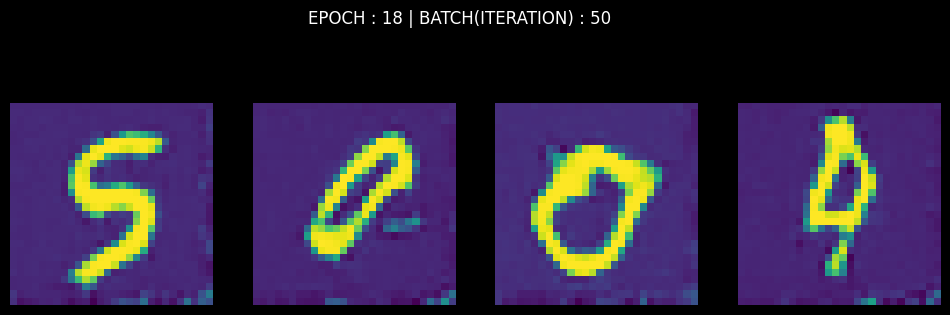

[Epoch: 18/25] [Batch: 235/235] [D loss: 0.411340] [G loss: 0.864904]


  0%|          | 0/235 [00:00<?, ?it/s]

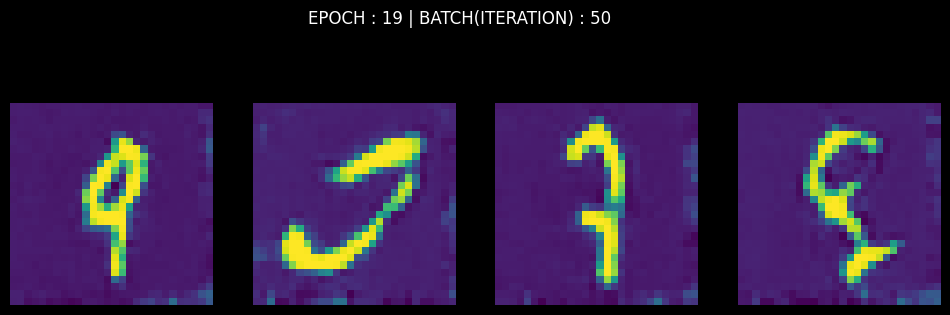

[Epoch: 19/25] [Batch: 235/235] [D loss: 0.146150] [G loss: 2.804434]


  0%|          | 0/235 [00:00<?, ?it/s]

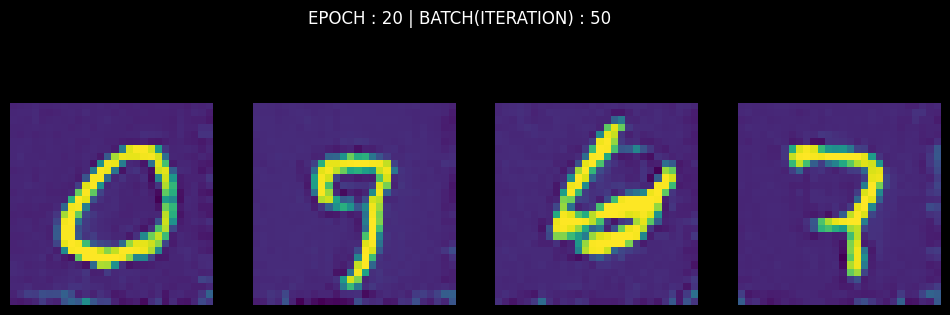

[Epoch: 20/25] [Batch: 235/235] [D loss: 0.156409] [G loss: 2.467554]


  0%|          | 0/235 [00:00<?, ?it/s]

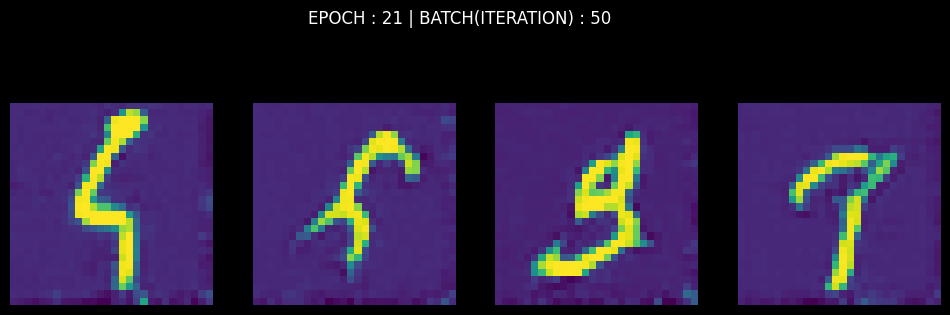

[Epoch: 21/25] [Batch: 235/235] [D loss: 0.307988] [G loss: 1.942754]


  0%|          | 0/235 [00:00<?, ?it/s]

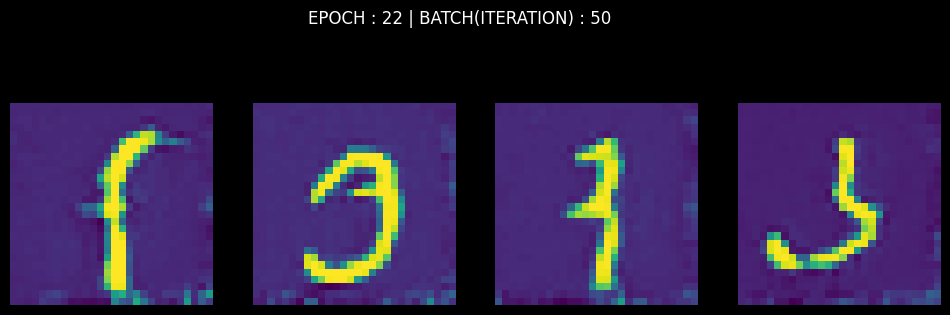

[Epoch: 22/25] [Batch: 235/235] [D loss: 0.349253] [G loss: 3.045132]


  0%|          | 0/235 [00:00<?, ?it/s]

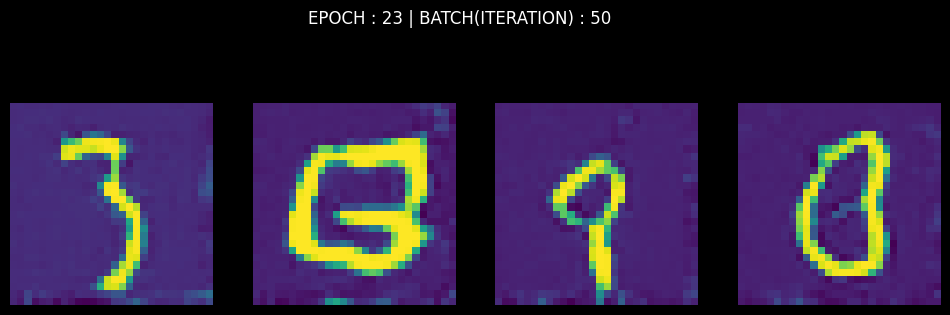

[Epoch: 23/25] [Batch: 235/235] [D loss: 0.251261] [G loss: 1.816387]


  0%|          | 0/235 [00:00<?, ?it/s]

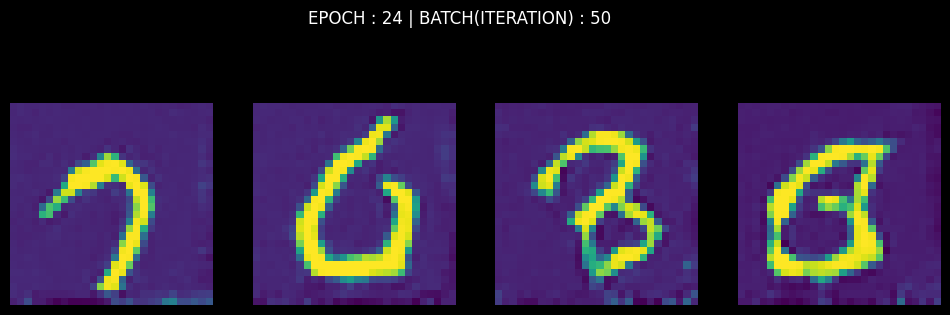

[Epoch: 24/25] [Batch: 235/235] [D loss: 0.367039] [G loss: 2.574612]


  0%|          | 0/235 [00:00<?, ?it/s]

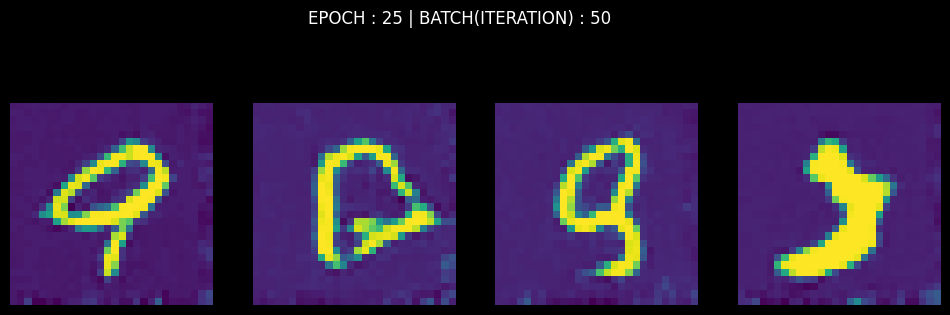

[Epoch: 25/25] [Batch: 235/235] [D loss: 0.312810] [G loss: 4.050688]


In [70]:
n_epochs = 25 # suggested default = 200
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(tqdm(dataloader)): # This code(enumerate) is dealt with once more in the *TEST_CODE below.
                                                     # Used 'tqdm' for showing progress

        # Adversarial ground truths (For more detail, refer *Read_More below)
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False) # imgs.size(0) == batch_size(1 batch) == 64, *TEST_CODE
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False) # And Variable is for caclulate gradient. In fact, you can use it, but you don't have to.
                                                                                # requires_grad=False is default in tensor type. *Read_More

        # Configure input
        real_imgs = imgs.type(Tensor) # As mentioned, it is no longer necessary to wrap the tensor in a Variable.
      # real_imgs = Variable(imgs.type(Tensor)) # requires_grad=False, Default! It's same.

# ------------
# Train Generator
# ------------
        optimizer_G.zero_grad()

        # sample noise 'z' as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim)))) # Random sampling Tensor(batch_size, latent_dim) of Gaussian distribution
        # z.shape == torch.Size([64, 100])

        # Generate a batch of images
        gen_imgs = generator(z)
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs).reshape(-1, 1), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)

        g_loss.backward()
        optimizer_G.step()

# ------------
# Train Discriminator
# ------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs).reshape(-1, 1), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()).reshape(-1, 1), fake) # We are learning the discriminator now. So have to use detach()

        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()# If didn't use detach() for gen_imgs, all weights of the generator will be calculated with backward().
        optimizer_D.step()



# ------------
# Real Time Visualization (While Training)
# ------------



        if ((i+1) % sample_interval) == 50: # show while batch - 200/657, 400/657, 600/657
            sample_z_in_train = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
            # z.shape == torch.Size([64, 100])
            sample_gen_imgs_in_train = generator(sample_z_in_train).detach().cpu()
            # gen_imgs.shape == torch.Size([64, 1, 28, 28])
            display_images(None, sample_gen_imgs_in_train, epoch=epoch, iteration=i)
    print(
        "[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, n_epochs, i+1, len(dataloader), d_loss.item(), g_loss.item())
    )

 # DCCGAN

В случае условной генерации мы подаем метку **y** в генератор и дискриминатор, что помогает нашей сети не тратить силы и веса на разделение объектов разных классов в латентном пространстве, в результате чего она для каждого класса может выучить отдельное представление, учитывающее только разброс по вариантам объектов в этом классе. Условие может быть любым, например, генерация конкретной цифры. Разумеется, в этом случае нам для обучения дискриминатора потребуется уже размеченный датасет.


<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/rnn/cgan_scheme.png" alt="Drawing" width= "800px;"/>

Условием в данном случае будет метка класса или label, которая на рисунке обозначена Y. Label добавляется к случайному шуму, тем самым мы говорим генератору генерировать случайное изображение нужного класса. Так же он подаётся в дискриминатор в качестве входа, чтобы дискриминатор знал какое изображение классифицировать как реальное, а какое как вымышленное.


 В исходной  статьей применение условных GAN были не слишком впечатляющими, но быстро стали появляться очень интересные новые работы. Например в качестве объектов используются фотографии человеческих лиц, а в качестве дополнительной информации - возраст человека на фотографии. Такой условный GAN способен порождать лица заданного возраста; более того, по фотографии лица можно сначала отобразить его в пространство признаков, а потом изменить признак возраста и породить новую фотографию, таким образом состарив или омолодив человека на фотографии! Для этого нужна чуть более сложная архитектура, вдаваться в которую мы не будем. Другое развитие идея изменения человеческих лиц получила [в следующей статье](https://arxiv.org/pdf/1611.06355.pdf), где условия имеют физический смысл - "светлые волосы", "лысина", "очки" и в модели есть специальные кодировщик, которые распознает эти признаки.Получается что теоретически можно распознать признаки на фотографии, искуственно заменить некоторые из них (перекрасить волосы, убрать лысину, надеть очки), а затем породить фотографию с другими признаками.
Еще одна интересная модификация условных GAN - InfoGan, добавляет к обычной задачи оптимизации, решаемой в GAN, дополнительные теоретико-информационные ограничения. Задача состоит в том, чтобы обучить на скрытом слое не просто хорошее представление, из которого можно сэмплировать, а распутанное представление (**disentangled represention**), в котором отдельныее признаки имеют естественную интерпретацию.Например, хотелось бы чтобы признаки у GAN генерирующие человеческое лицо, соответствовали цвету глаз, форме носа и тому подобным естественным особенностям.

In [71]:
n_classes = 10

In [72]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.l1 = nn.Sequential(nn.Linear(latent_dim + n_classes, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img
summary(Generator().to(device), [(1, 100), (1,)], dtypes=[torch.float, torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 1, 28, 28]            --
├─Embedding: 1-1                         [1, 10]                   100
├─Sequential: 1-2                        [1, 6272]                 --
│    └─Linear: 2-1                       [1, 6272]                 696,192
├─Sequential: 1-3                        [1, 1, 28, 28]            --
│    └─BatchNorm2d: 2-2                  [1, 128, 7, 7]            256
│    └─Upsample: 2-3                     [1, 128, 14, 14]          --
│    └─Conv2d: 2-4                       [1, 128, 14, 14]          147,584
│    └─BatchNorm2d: 2-5                  [1, 128, 14, 14]          256
│    └─LeakyReLU: 2-6                    [1, 128, 14, 14]          --
│    └─Upsample: 2-7                     [1, 128, 28, 28]          --
│    └─Conv2d: 2-8                       [1, 64, 28, 28]           73,792
│    └─BatchNorm2d: 2-9                  [1, 64, 28, 28]           1

In [73]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity
summary(Generator().to(device), [(1, 100), (1,)], dtypes=[torch.float, torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 1, 28, 28]            --
├─Embedding: 1-1                         [1, 10]                   100
├─Sequential: 1-2                        [1, 6272]                 --
│    └─Linear: 2-1                       [1, 6272]                 696,192
├─Sequential: 1-3                        [1, 1, 28, 28]            --
│    └─BatchNorm2d: 2-2                  [1, 128, 7, 7]            256
│    └─Upsample: 2-3                     [1, 128, 14, 14]          --
│    └─Conv2d: 2-4                       [1, 128, 14, 14]          147,584
│    └─BatchNorm2d: 2-5                  [1, 128, 14, 14]          256
│    └─LeakyReLU: 2-6                    [1, 128, 14, 14]          --
│    └─Upsample: 2-7                     [1, 128, 28, 28]          --
│    └─Conv2d: 2-8                       [1, 64, 28, 28]           73,792
│    └─BatchNorm2d: 2-9                  [1, 64, 28, 28]           1

In [78]:
adversarial_loss = torch.nn.BCELoss()
generator = Generator()
discriminator = Discriminator()

In [79]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [80]:
# suggested default - beta parameters (decay of first order momentum of gradients)
b1 = 0.5
b2 = 0.999

# suggested default - learning rate
lr = 0.0002
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1,b2))
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

  0%|          | 0/235 [00:00<?, ?it/s]

tensor([6, 5, 0, 4], device='cuda:0')


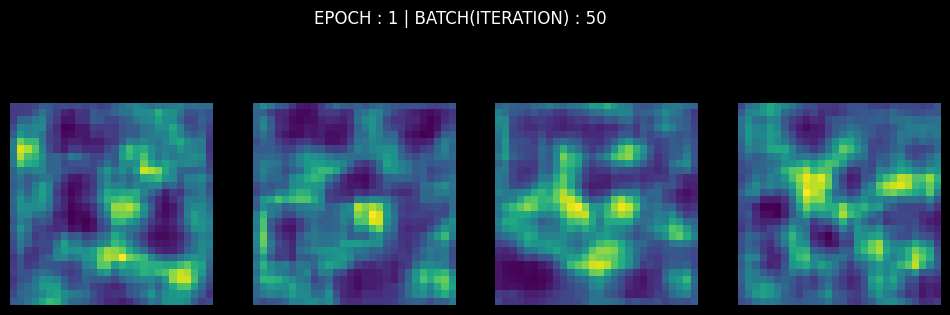

[Epoch: 1/25] [Batch: 235/235] [D loss: 0.587247] [G loss: 0.777289]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([1, 7, 9, 7], device='cuda:0')


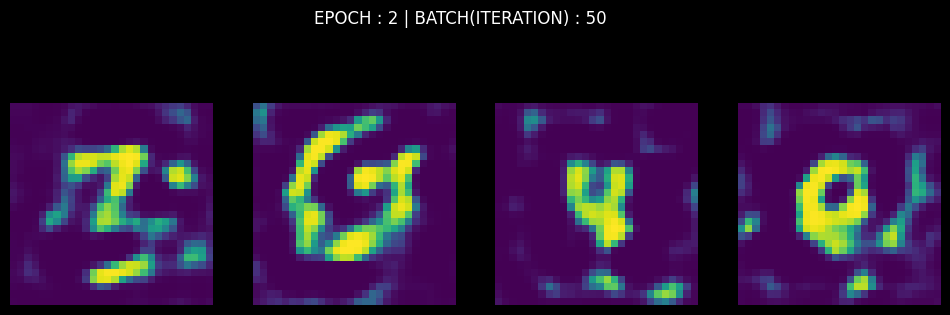

[Epoch: 2/25] [Batch: 235/235] [D loss: 0.558500] [G loss: 1.120192]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([3, 5, 6, 1], device='cuda:0')


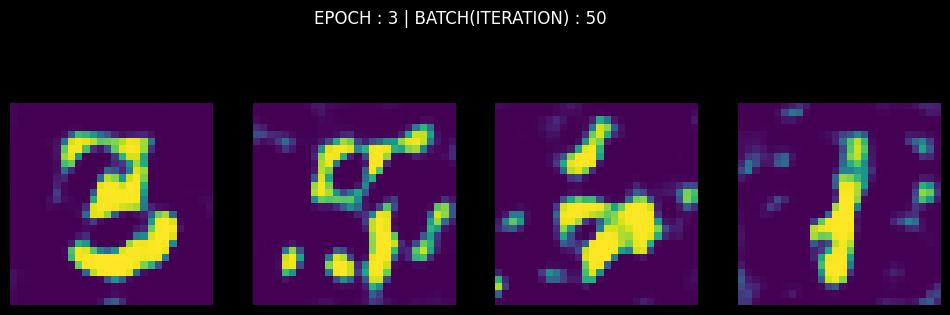

[Epoch: 3/25] [Batch: 235/235] [D loss: 0.644048] [G loss: 1.229167]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([0, 5, 0, 8], device='cuda:0')


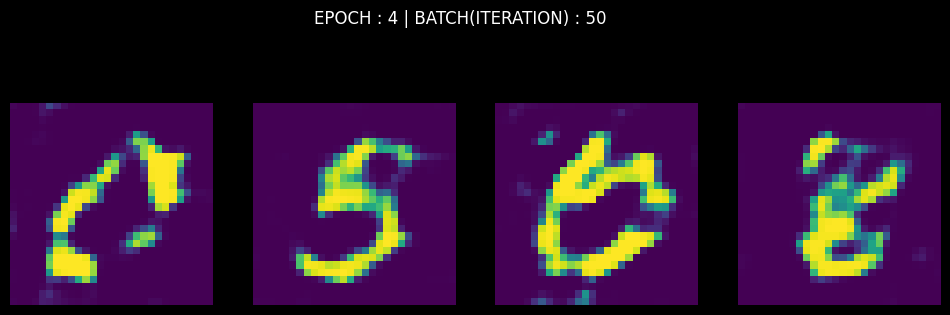

[Epoch: 4/25] [Batch: 235/235] [D loss: 0.559537] [G loss: 0.832273]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([3, 9, 8, 4], device='cuda:0')


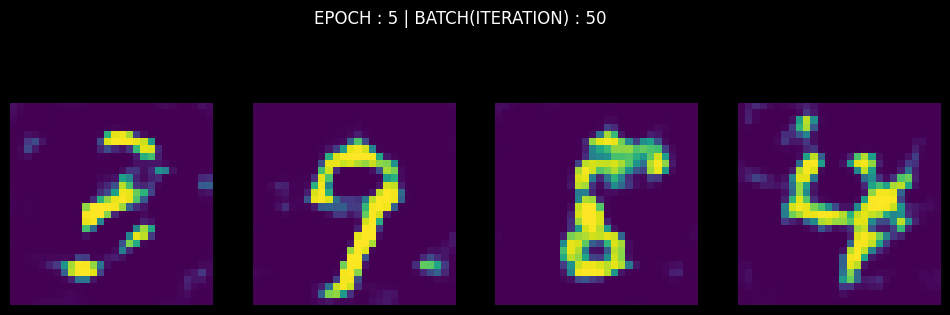

[Epoch: 5/25] [Batch: 235/235] [D loss: 0.560090] [G loss: 0.871342]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([6, 5, 6, 5], device='cuda:0')


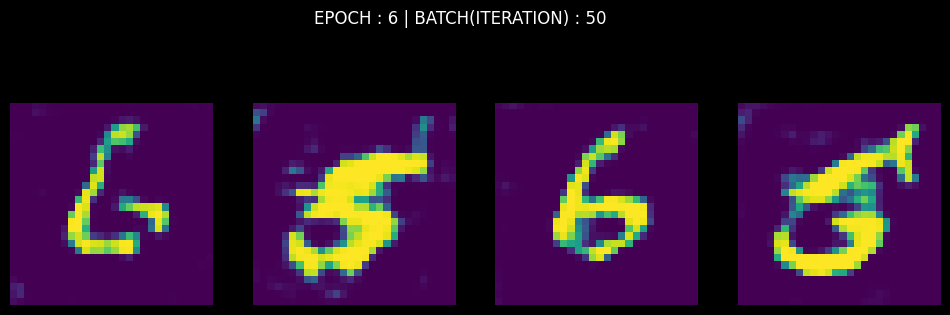

[Epoch: 6/25] [Batch: 235/235] [D loss: 0.700680] [G loss: 1.063024]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([5, 3, 1, 0], device='cuda:0')


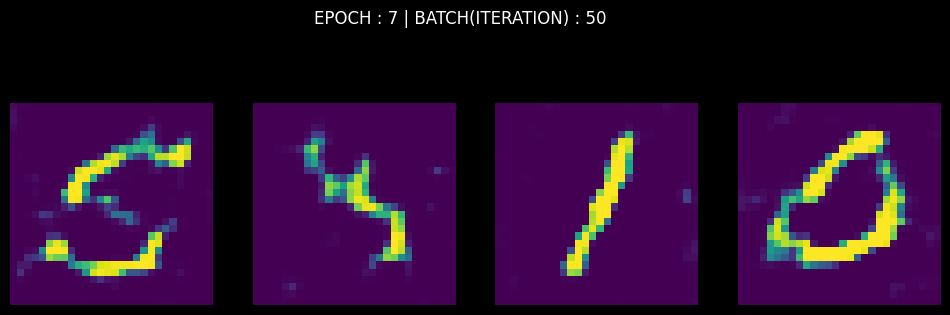

[Epoch: 7/25] [Batch: 235/235] [D loss: 0.619312] [G loss: 0.986413]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([2, 6, 6, 2], device='cuda:0')


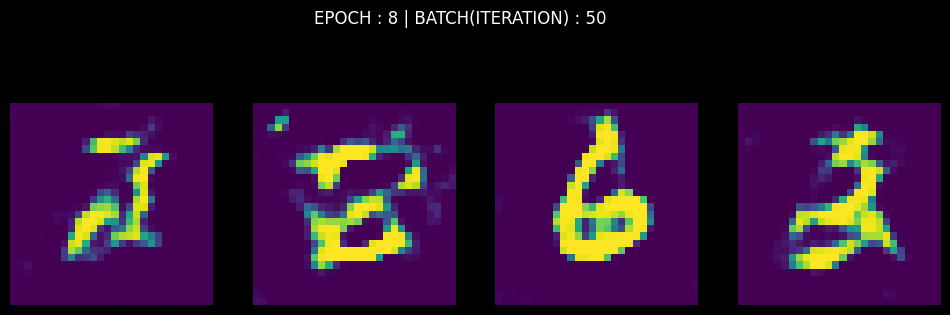

[Epoch: 8/25] [Batch: 235/235] [D loss: 0.637229] [G loss: 0.882119]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([9, 9, 7, 5], device='cuda:0')


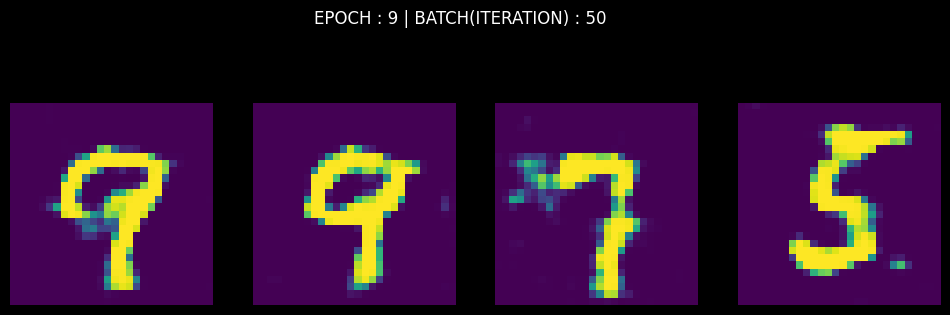

[Epoch: 9/25] [Batch: 235/235] [D loss: 0.558746] [G loss: 0.846885]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([5, 6, 9, 0], device='cuda:0')


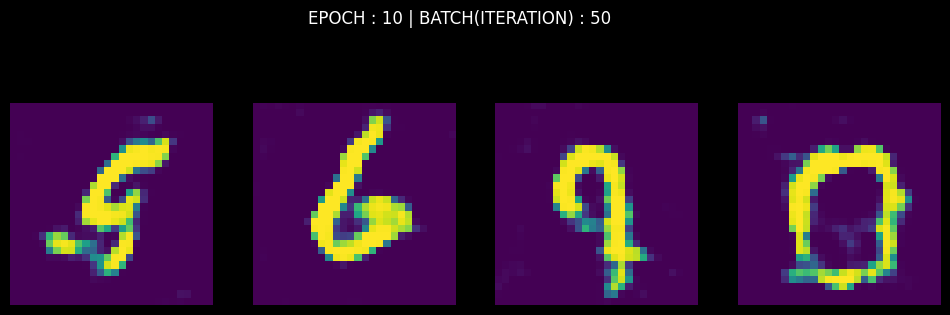

[Epoch: 10/25] [Batch: 235/235] [D loss: 0.591099] [G loss: 0.832995]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([1, 4, 3, 8], device='cuda:0')


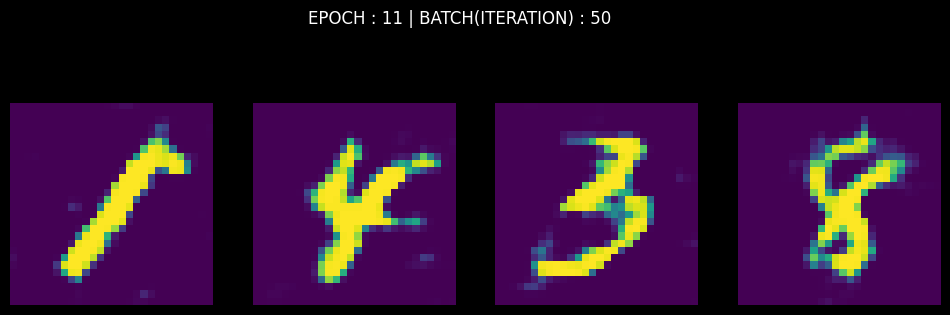

[Epoch: 11/25] [Batch: 235/235] [D loss: 0.643531] [G loss: 1.001217]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([1, 3, 2, 9], device='cuda:0')


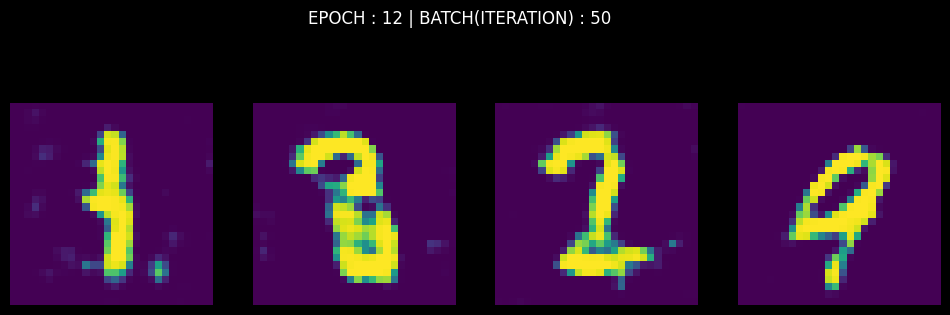

[Epoch: 12/25] [Batch: 235/235] [D loss: 0.663442] [G loss: 0.792891]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([6, 8, 2, 0], device='cuda:0')


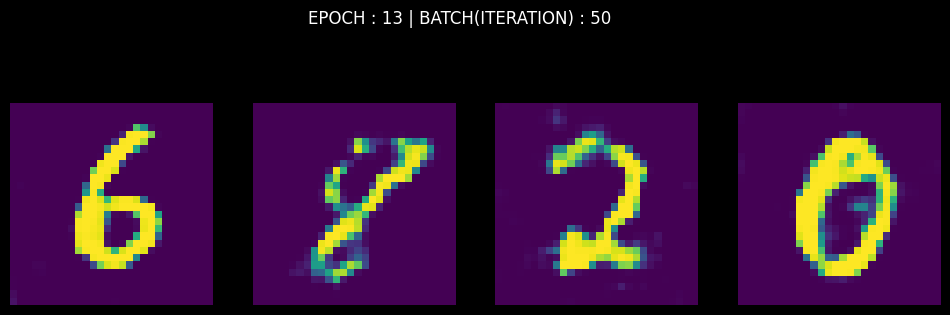

[Epoch: 13/25] [Batch: 235/235] [D loss: 0.620774] [G loss: 0.804356]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([5, 7, 6, 0], device='cuda:0')


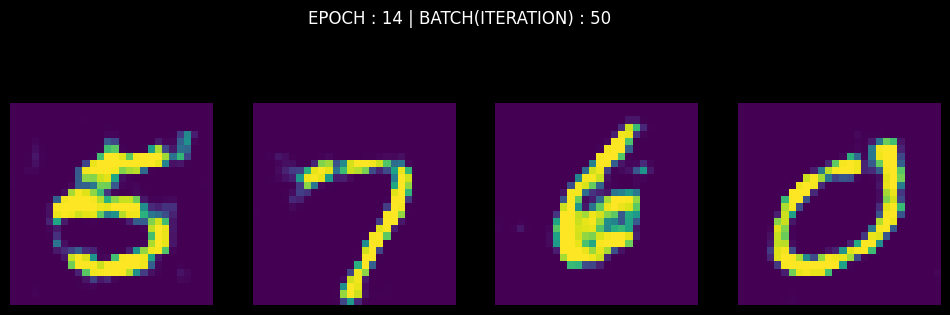

[Epoch: 14/25] [Batch: 235/235] [D loss: 0.626664] [G loss: 0.954481]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([8, 7, 2, 3], device='cuda:0')


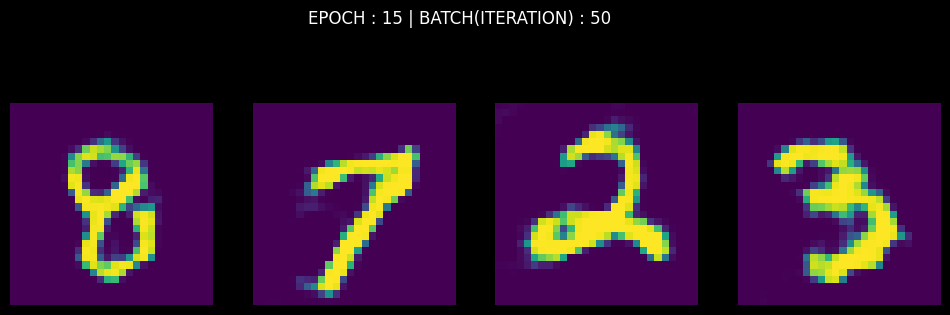

[Epoch: 15/25] [Batch: 235/235] [D loss: 0.613168] [G loss: 0.766947]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([1, 7, 8, 1], device='cuda:0')


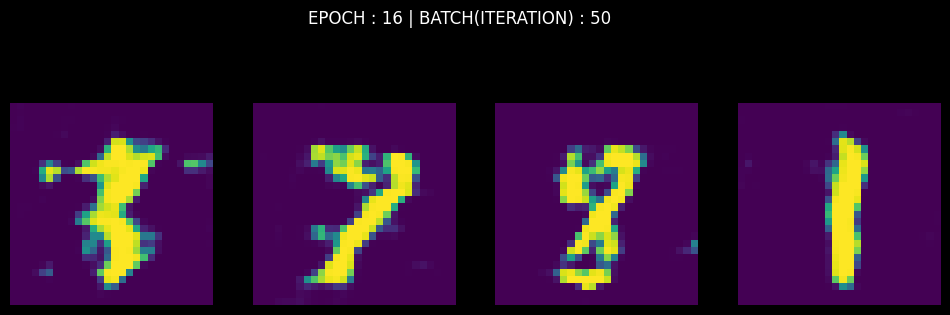

[Epoch: 16/25] [Batch: 235/235] [D loss: 0.662760] [G loss: 0.659135]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([0, 9, 5, 4], device='cuda:0')


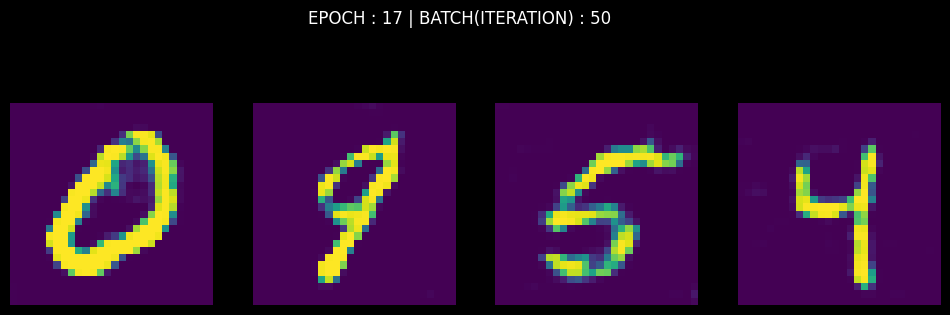

[Epoch: 17/25] [Batch: 235/235] [D loss: 0.717489] [G loss: 0.569367]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([9, 9, 0, 2], device='cuda:0')


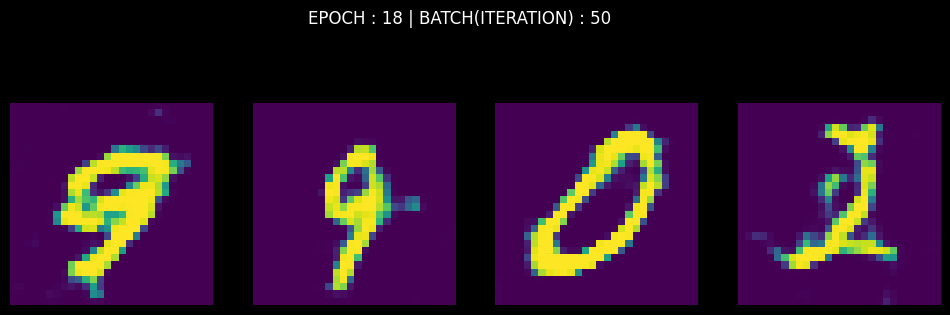

[Epoch: 18/25] [Batch: 235/235] [D loss: 0.680104] [G loss: 0.803307]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([2, 1, 5, 1], device='cuda:0')


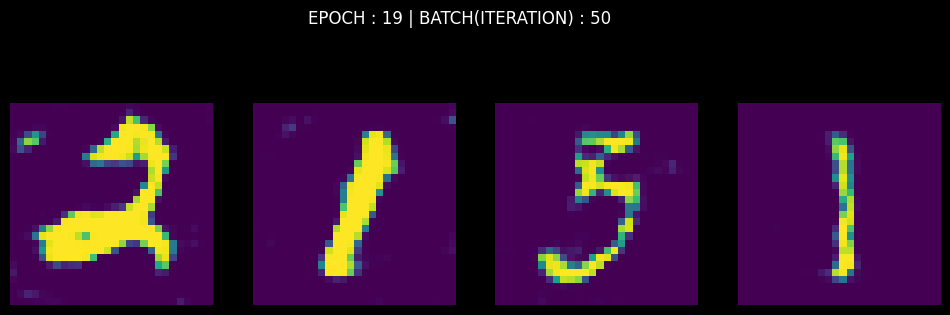

[Epoch: 19/25] [Batch: 235/235] [D loss: 0.690750] [G loss: 0.773320]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([2, 3, 6, 8], device='cuda:0')


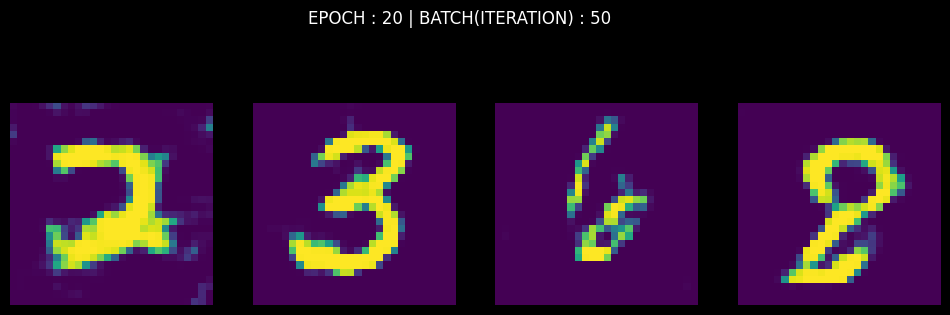

[Epoch: 20/25] [Batch: 235/235] [D loss: 0.647936] [G loss: 0.813121]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([9, 9, 1, 8], device='cuda:0')


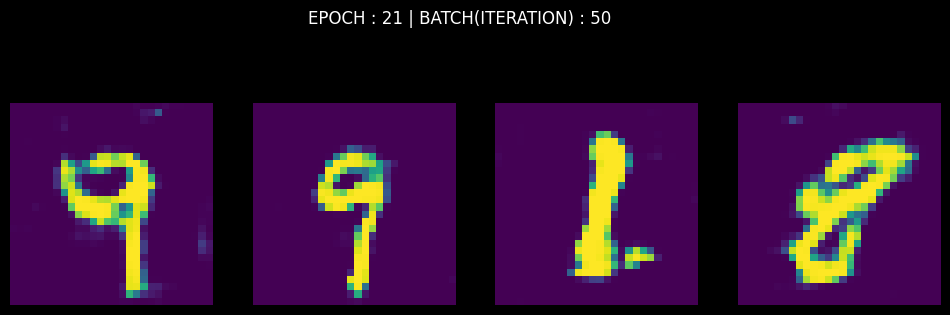

[Epoch: 21/25] [Batch: 235/235] [D loss: 0.669082] [G loss: 0.590146]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([7, 7, 8, 2], device='cuda:0')


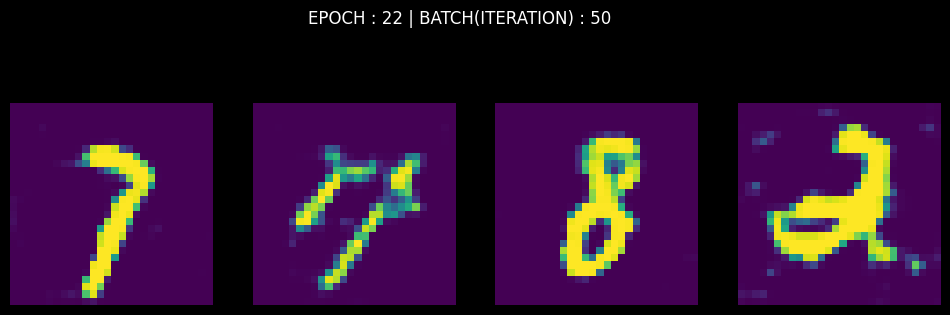

[Epoch: 22/25] [Batch: 235/235] [D loss: 0.647713] [G loss: 0.755678]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([2, 8, 0, 8], device='cuda:0')


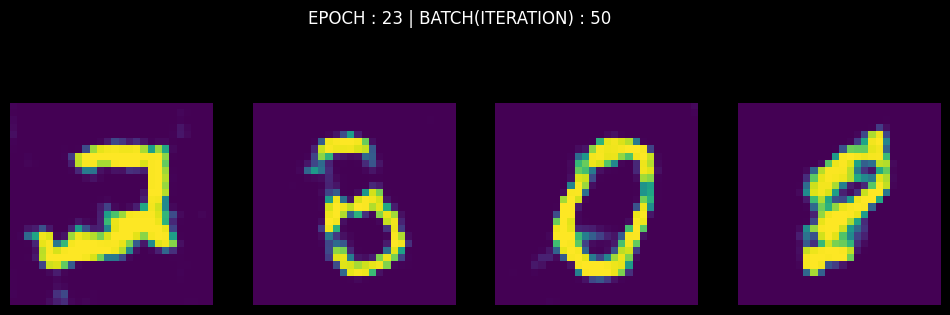

[Epoch: 23/25] [Batch: 235/235] [D loss: 0.648049] [G loss: 0.757481]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([9, 0, 2, 6], device='cuda:0')


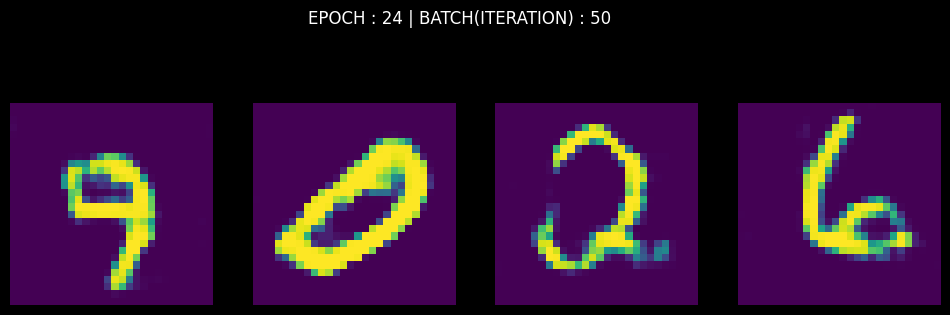

[Epoch: 24/25] [Batch: 235/235] [D loss: 0.672534] [G loss: 0.861692]


  0%|          | 0/235 [00:00<?, ?it/s]

tensor([9, 2, 3, 0], device='cuda:0')


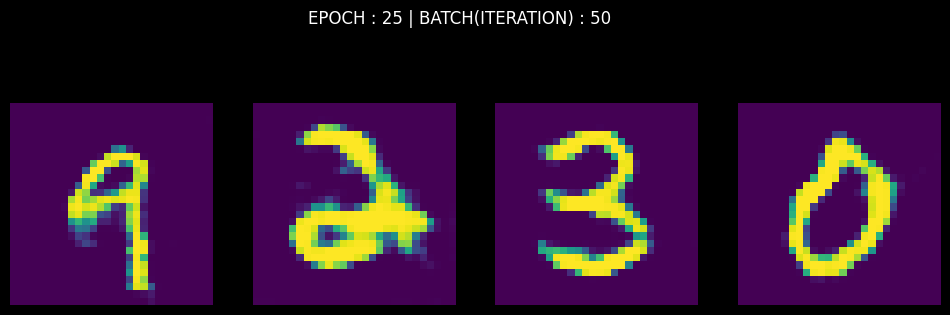

[Epoch: 25/25] [Batch: 235/235] [D loss: 0.671101] [G loss: 0.774145]


In [81]:
n_epochs = 25 # suggested default = 200
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(tqdm(dataloader)): # This code(enumerate) is dealt with once more in the *TEST_CODE below.
                                                     # Used 'tqdm' for showing progress

        # Adversarial ground truths (For more detail, refer *Read_More below)
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False) # imgs.size(0) == batch_size(1 batch) == 64, *TEST_CODE
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False) # And Variable is for caclulate gradient. In fact, you can use it, but you don't have to.
                                                                                # requires_grad=False is default in tensor type. *Read_More

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor)) # As mentioned, it is no longer necessary to wrap the tensor in a Variable.
        labels = Variable(labels.type(LongTensor))
      # real_imgs = Variable(imgs.type(Tensor)) # requires_grad=False, Default! It's same.

# ------------
# Train Generator
# ------------
        optimizer_G.zero_grad()

        # sample noise 'z' as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (imgs.size(0), latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, imgs.size(0))))
        # z.shape == torch.Size([64, 100])

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)


        g_loss.backward()
        optimizer_G.step()

# ------------
# Train Discriminator
# ------------
        optimizer_D.zero_grad()

        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)
        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()# If didn't use detach() for gen_imgs, all weights of the generator will be calculated with backward().
        optimizer_D.step()



# ------------
# Real Time Visualization (While Training)
# ------------
        if ((i+1) % sample_interval) == 50: # show while batch - 200/657, 400/657, 600/657
            и

    print(
        "[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, n_epochs, i+1, len(dataloader), d_loss.item(), g_loss.item())
    )


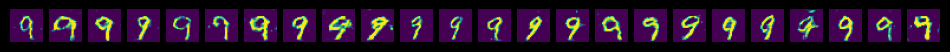

In [109]:
batch_size = 24
number = 9
sample_z_in_train = FloatTensor(np.random.normal(0, 1, (batch_size ,latent_dim)))
gen_labels_in_train = Variable(LongTensor(np.random.randint(number, number+1, batch_size)))
sample_gen_imgs_in_train = generator(sample_z_in_train, gen_labels_in_train).detach().cpu()
display_images(None, sample_gen_imgs_in_train, row_count=batch_size)

## Упражнения

Попробуйте:

* использовать другой датасет, например FashionMNIST
* заменить loss на MSE
* поменять размерность латентного пространства
* попробовать другой оптимизатор

## Дополнительно: модификации GAN

Разных вариаций GAN было придумано неимоверное количество. Перечислять их все не хватит никакого времени, например заметен рост новых решений для распознавания или сегментации с использованием идей GAN. Подробнее можно почитать, например <a href="https://paperswithcode.com/methods/category/generative-models">тут</a>.

Несколько вариаций, которые хочется упомянуть:

* **EBGAN** (Energy-based Generative Adversarial Network) рассматривает дискриминатор как функцию энергии, которая приписывает низкие энергии областям вблизи области, соотвествующей нашим данным, и более высокие энергии другим регионам, подобно вероятностным моделям. Таким образом, от генератора мы будем ждать создания объектов с минимальными значениями "энергии".

* **InfoGAN**: не подаем label в дискриминатор, а ждем от него классификации в соответствии с классом, который мы хотим получить от генератора.

*  **AC-GAN** (auxiliary classifier) различие заключается в том, что дискриминатор дожен помимо распознавания реальных и фейковых изображений ещё и классифицировать их. Он имеет эффект стабилизации процесса обучения и позволяет генерировать большие высококачественные изображения, изучая представление в скрытом пространстве, которое не зависит от метки класса.

<img src="https://raw.githubusercontent.com/hussain7/tensorflow-generative-model-collections/master/assets/etc/GAN_structure.png" alt="Drawing" width= "800px;"/>